<a id=toc></a>

<center><h1>Transfer Learning | Snake Species Identification</h1></center>
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#00C4FF;
              border-bottom-style: solid;'></div>
<br>

<center>
    <figure>
        <img src="https://i.gifer.com/4AbY.gif" alt ="Snake Species gif" style='width:55%;'>
        <figcaption>
            Source: <a href="">Snake Species Identification</a>
        </figcaption>
    </figure>
</center>

In [1]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
class CFG:
    EPOCHS = 20 
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATASET_PATH = "/kaggle/input/snake-species-jpg/Snake_Species_JPG/"


In [3]:
%%time
dataset_images = glob.glob(f"{DATASET_PATH}**/*.jpg")

CPU times: user 15.5 ms, sys: 18.3 ms, total: 33.8 ms
Wall time: 433 ms


In [4]:
# Get dataset size
total = len(dataset_images)

# View samples counts
print(f'TOTAL: {total}')

TOTAL: 5628


In [5]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [6]:
# Build the Dataset DataFrame 
dataset_df = build_df(dataset_images, generate_labels(dataset_images))

In [7]:
# View first 5 samples in the dataset
dataset_df.head(5)

image_path                label
0  /kaggle/input/snake-species-jpg/Snake_Species_...            green_pit
1  /kaggle/input/snake-species-jpg/Snake_Species_...        russels_viper
2  /kaggle/input/snake-species-jpg/Snake_Species_...       red_tailed_pit
3  /kaggle/input/snake-species-jpg/Snake_Species_...  greater_black_krait
4  /kaggle/input/snake-species-jpg/Snake_Species_...   lesser_black_krait

In [8]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

image_path                label  \
0  /kaggle/input/snake-species-jpg/Snake_Species_...            green_pit   
1  /kaggle/input/snake-species-jpg/Snake_Species_...        russels_viper   
2  /kaggle/input/snake-species-jpg/Snake_Species_...       red_tailed_pit   
3  /kaggle/input/snake-species-jpg/Snake_Species_...  greater_black_krait   
4  /kaggle/input/snake-species-jpg/Snake_Species_...   lesser_black_krait   
5  /kaggle/input/snake-species-jpg/Snake_Species_...  greater_black_krait   
6  /kaggle/input/snake-species-jpg/Snake_Species_...    monocellate_cobra   
7  /kaggle/input/snake-species-jpg/Snake_Species_...       red_tailed_pit   
8  /kaggle/input/snake-species-jpg/Snake_Species_...         common_krait   
9  /kaggle/input/snake-species-jpg/Snake_Species_...         common_krait   

   label_encoded  
0              4  
1              9  
2              8  
3              3  
4              6  
5              3  
6              7  
7              8  
8              2  
9              2

In [9]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 11
Classes: ['banded_krait' 'binoellate_cobra' 'common_krait' 'greater_black_krait'
 'green_pit' 'king_cobra' 'lesser_black_krait' 'monocellate_cobra'
 'red_tailed_pit' 'russels_viper' 'walls_krait']


In [10]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

def view_sample(image, label, color_map='gray', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
#     plt.savefig(f'/kaggle/working/{label}.jpg')
    return

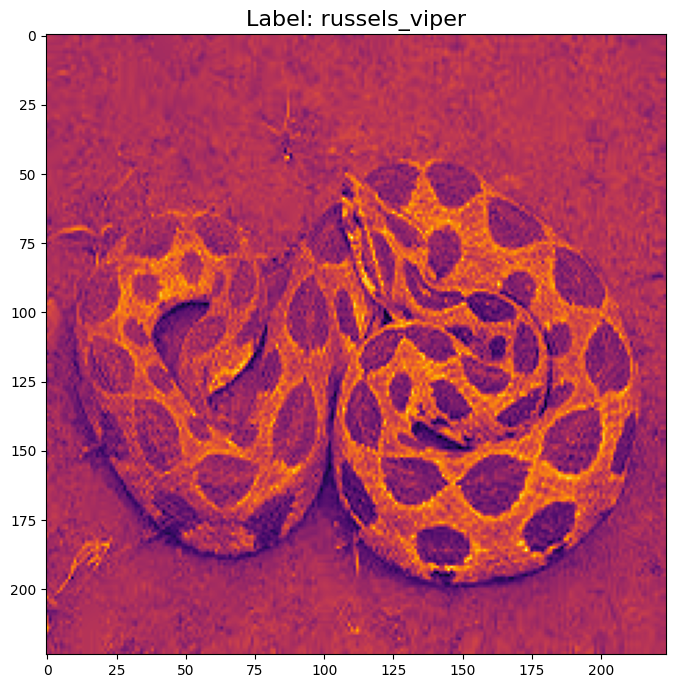

In [11]:
# Select random sample from train_df
idx = random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')

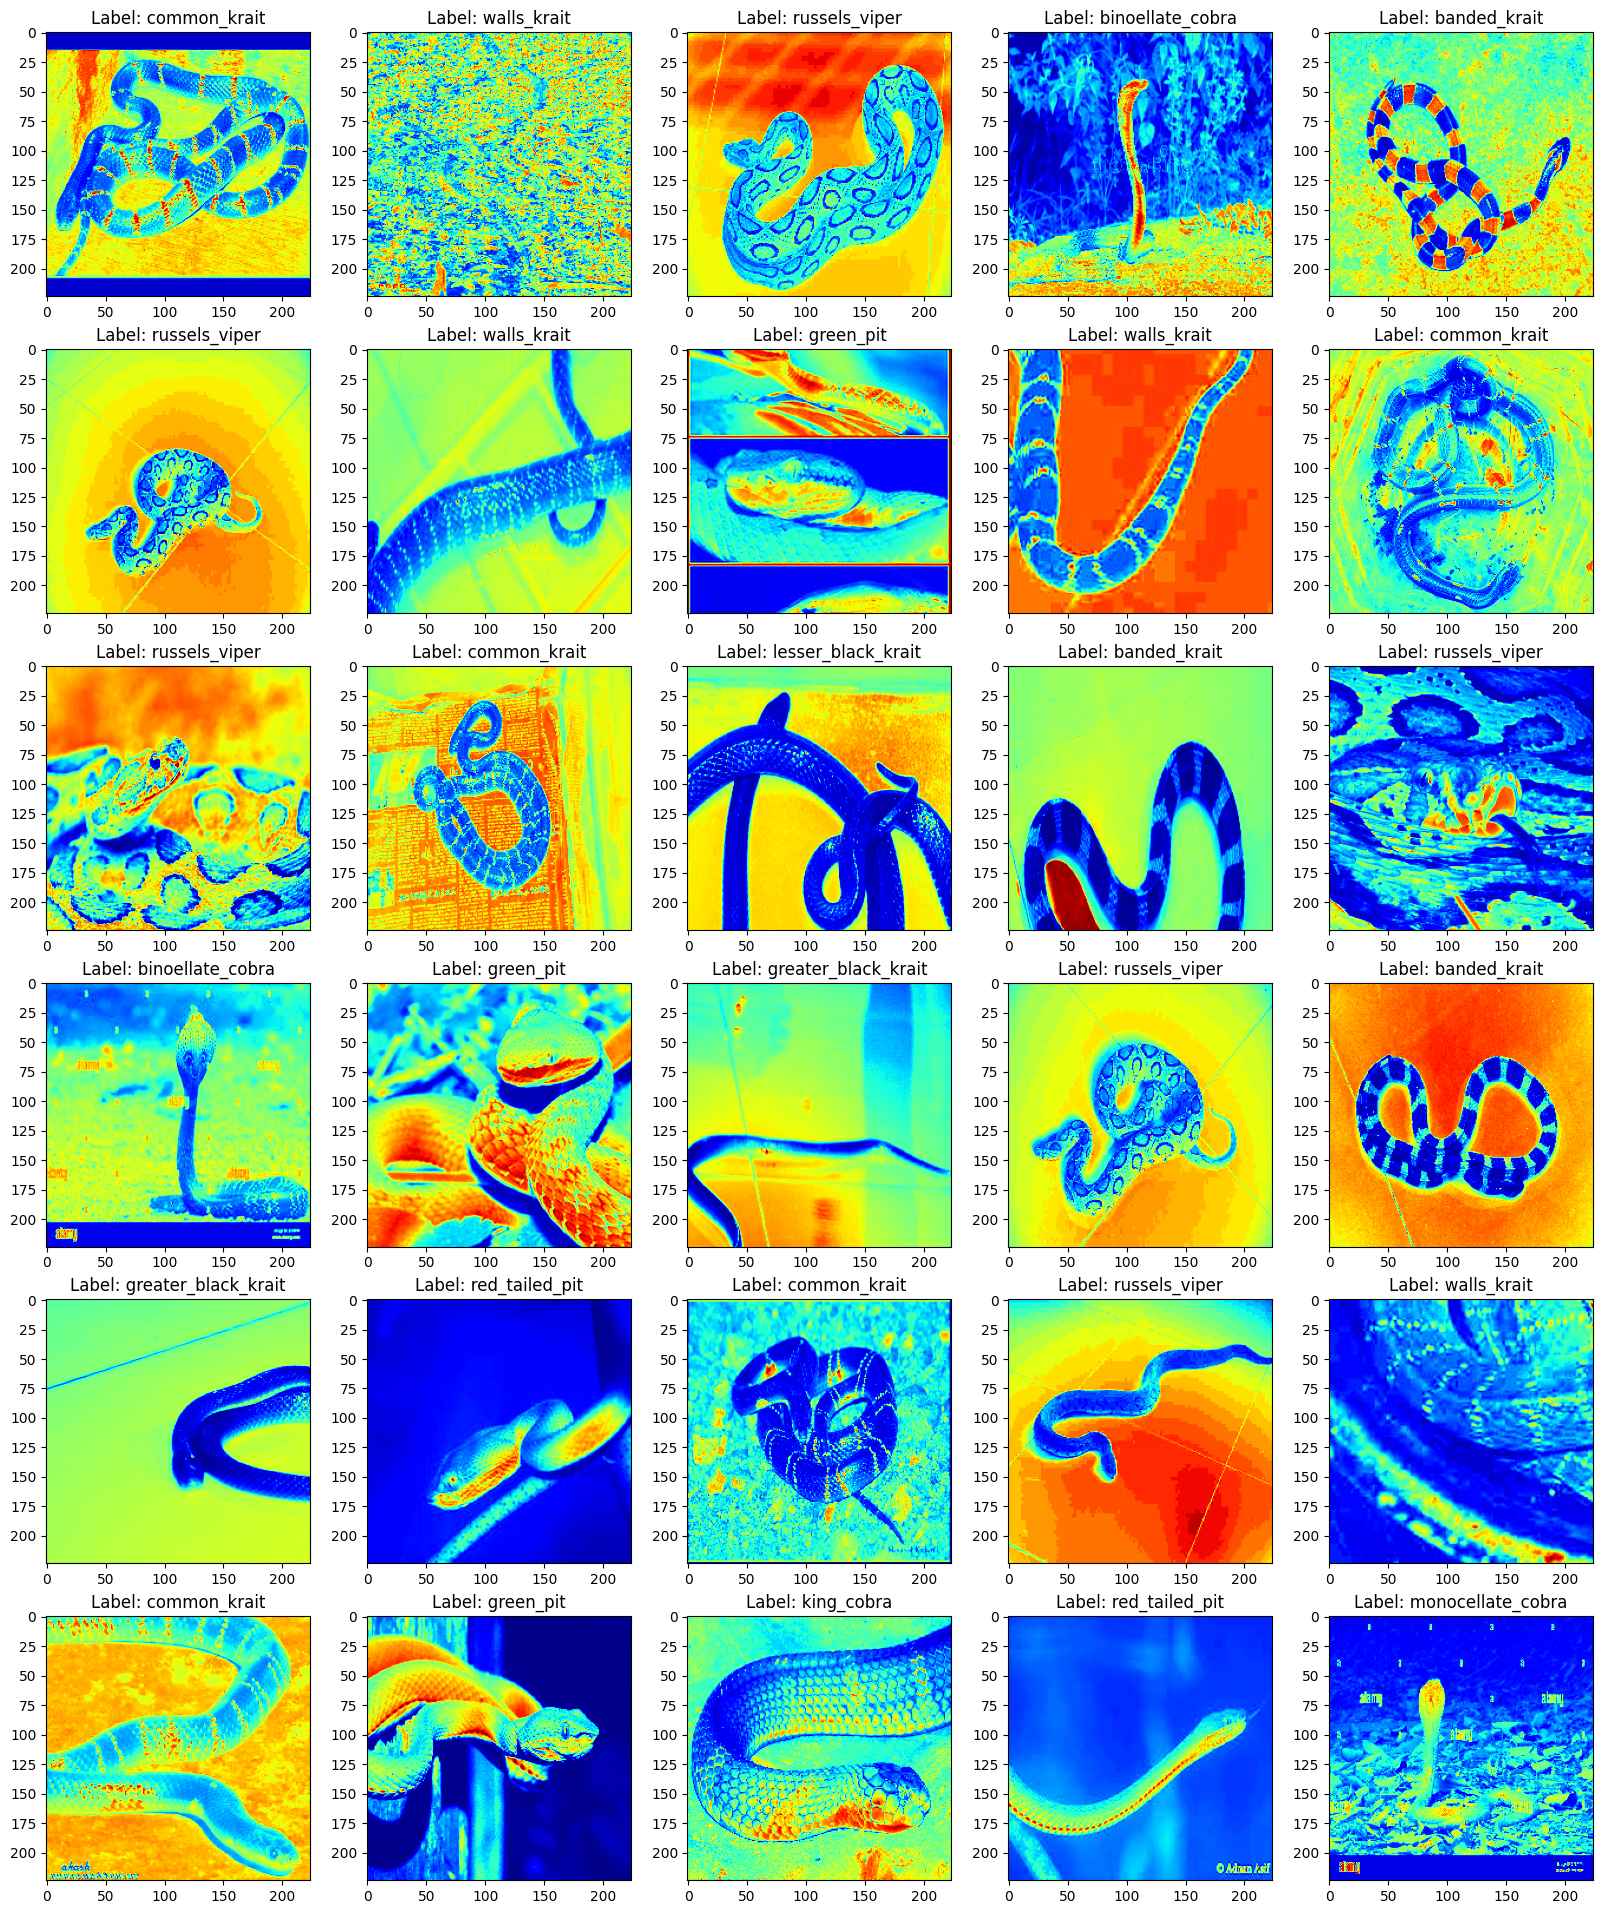

In [12]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='gray', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map);
    
    return

view_mulitiple_samples(dataset_df, _load, 
                       count=30, color_map='jet', 
                       fig_size=(20, 24))

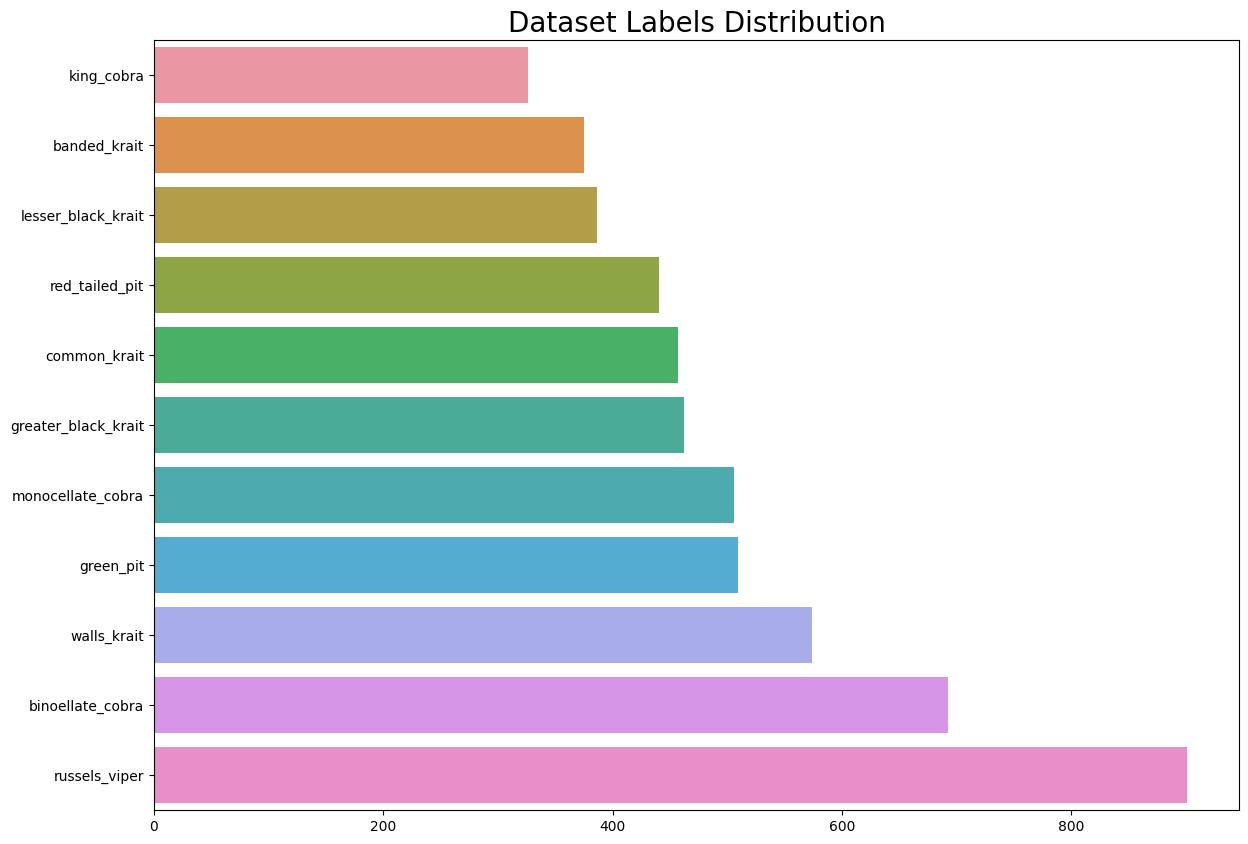

In [13]:
# Generate Figure
fig = plt.figure(figsize=(14, 10))

# Plot Labels Distribution
plt.title('Dataset Labels Distribution', fontsize=20)
distribution = dataset_df['label'].value_counts().sort_values()
sns.barplot(x=distribution.values,
            y=list(distribution.keys()),
            orient="h");


In [14]:
# Get insufficient labels
insufficient_labels = list(distribution[distribution.values < 10].keys())

# # Get insufficient labels indices from df
# insufficient_indices = pd.concat([dataset_df[dataset_df.label == _] for _ in insufficient_labels]).index

# # Remove insufficient labels
# dataset_df = dataset_df.drop(insufficient_indices).reset_index(drop=True)

In [15]:
dataset_df['label'].value_counts().sort_values()

label
king_cobra             326
banded_krait           375
lesser_black_krait     386
red_tailed_pit         440
common_krait           457
greater_black_krait    462
monocellate_cobra      506
green_pit              509
walls_krait            574
binoellate_cobra       692
russels_viper          901
Name: count, dtype: int64

# 2 | Data Preprocessing: Building An Input Data Pipeline

In [16]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

image_path                label  \
0  /kaggle/input/snake-species-jpg/Snake_Species_...            green_pit   
1  /kaggle/input/snake-species-jpg/Snake_Species_...        russels_viper   
2  /kaggle/input/snake-species-jpg/Snake_Species_...       red_tailed_pit   
3  /kaggle/input/snake-species-jpg/Snake_Species_...  greater_black_krait   
4  /kaggle/input/snake-species-jpg/Snake_Species_...   lesser_black_krait   
5  /kaggle/input/snake-species-jpg/Snake_Species_...  greater_black_krait   
6  /kaggle/input/snake-species-jpg/Snake_Species_...    monocellate_cobra   
7  /kaggle/input/snake-species-jpg/Snake_Species_...       red_tailed_pit   
8  /kaggle/input/snake-species-jpg/Snake_Species_...         common_krait   
9  /kaggle/input/snake-species-jpg/Snake_Species_...         common_krait   

   label_encoded  
0              4  
1              9  
2              8  
3              3  
4              6  
5              3  
6              7  
7              8  
8              2  
9              2

In [17]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 11
Classes: ['banded_krait' 'binoellate_cobra' 'common_krait' 'greater_black_krait'
 'green_pit' 'king_cobra' 'lesser_black_krait' 'monocellate_cobra'
 'red_tailed_pit' 'russels_viper' 'walls_krait']


In [18]:
# Create Train/Test split with Training Set
train_split_idx, val_test_split_idx, _, _ = train_test_split(dataset_df.index, 
                                                        dataset_df.label_encoded, 
                                                        test_size=0.4,
                                                        stratify=dataset_df.label_encoded,
                                                        random_state=CFG.SEED)

In [19]:
# Get training and validation data
train_df = dataset_df.iloc[train_split_idx].reset_index(drop=True)
val_test_df = dataset_df.iloc[val_test_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, val_test_df.shape

((3376, 3), (2252, 3))

In [20]:
# Create Train/Test split with Training Set
val_split_idx, test_split_idx, _, _ = train_test_split(val_test_df.index, 
                                                       val_test_df.label_encoded, 
                                                       test_size=0.6,
                                                       stratify=val_test_df.label_encoded,
                                                       random_state=CFG.SEED)

In [21]:
# Get validation and test data
val_df = dataset_df.iloc[val_split_idx].reset_index(drop=True)
test_df = dataset_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((900, 3), (1352, 3))

In [22]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}')
print(f'validation samples count:\t{val_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		3376
validation samples count:	900
test samples count:		1352
TOTAL:				5628


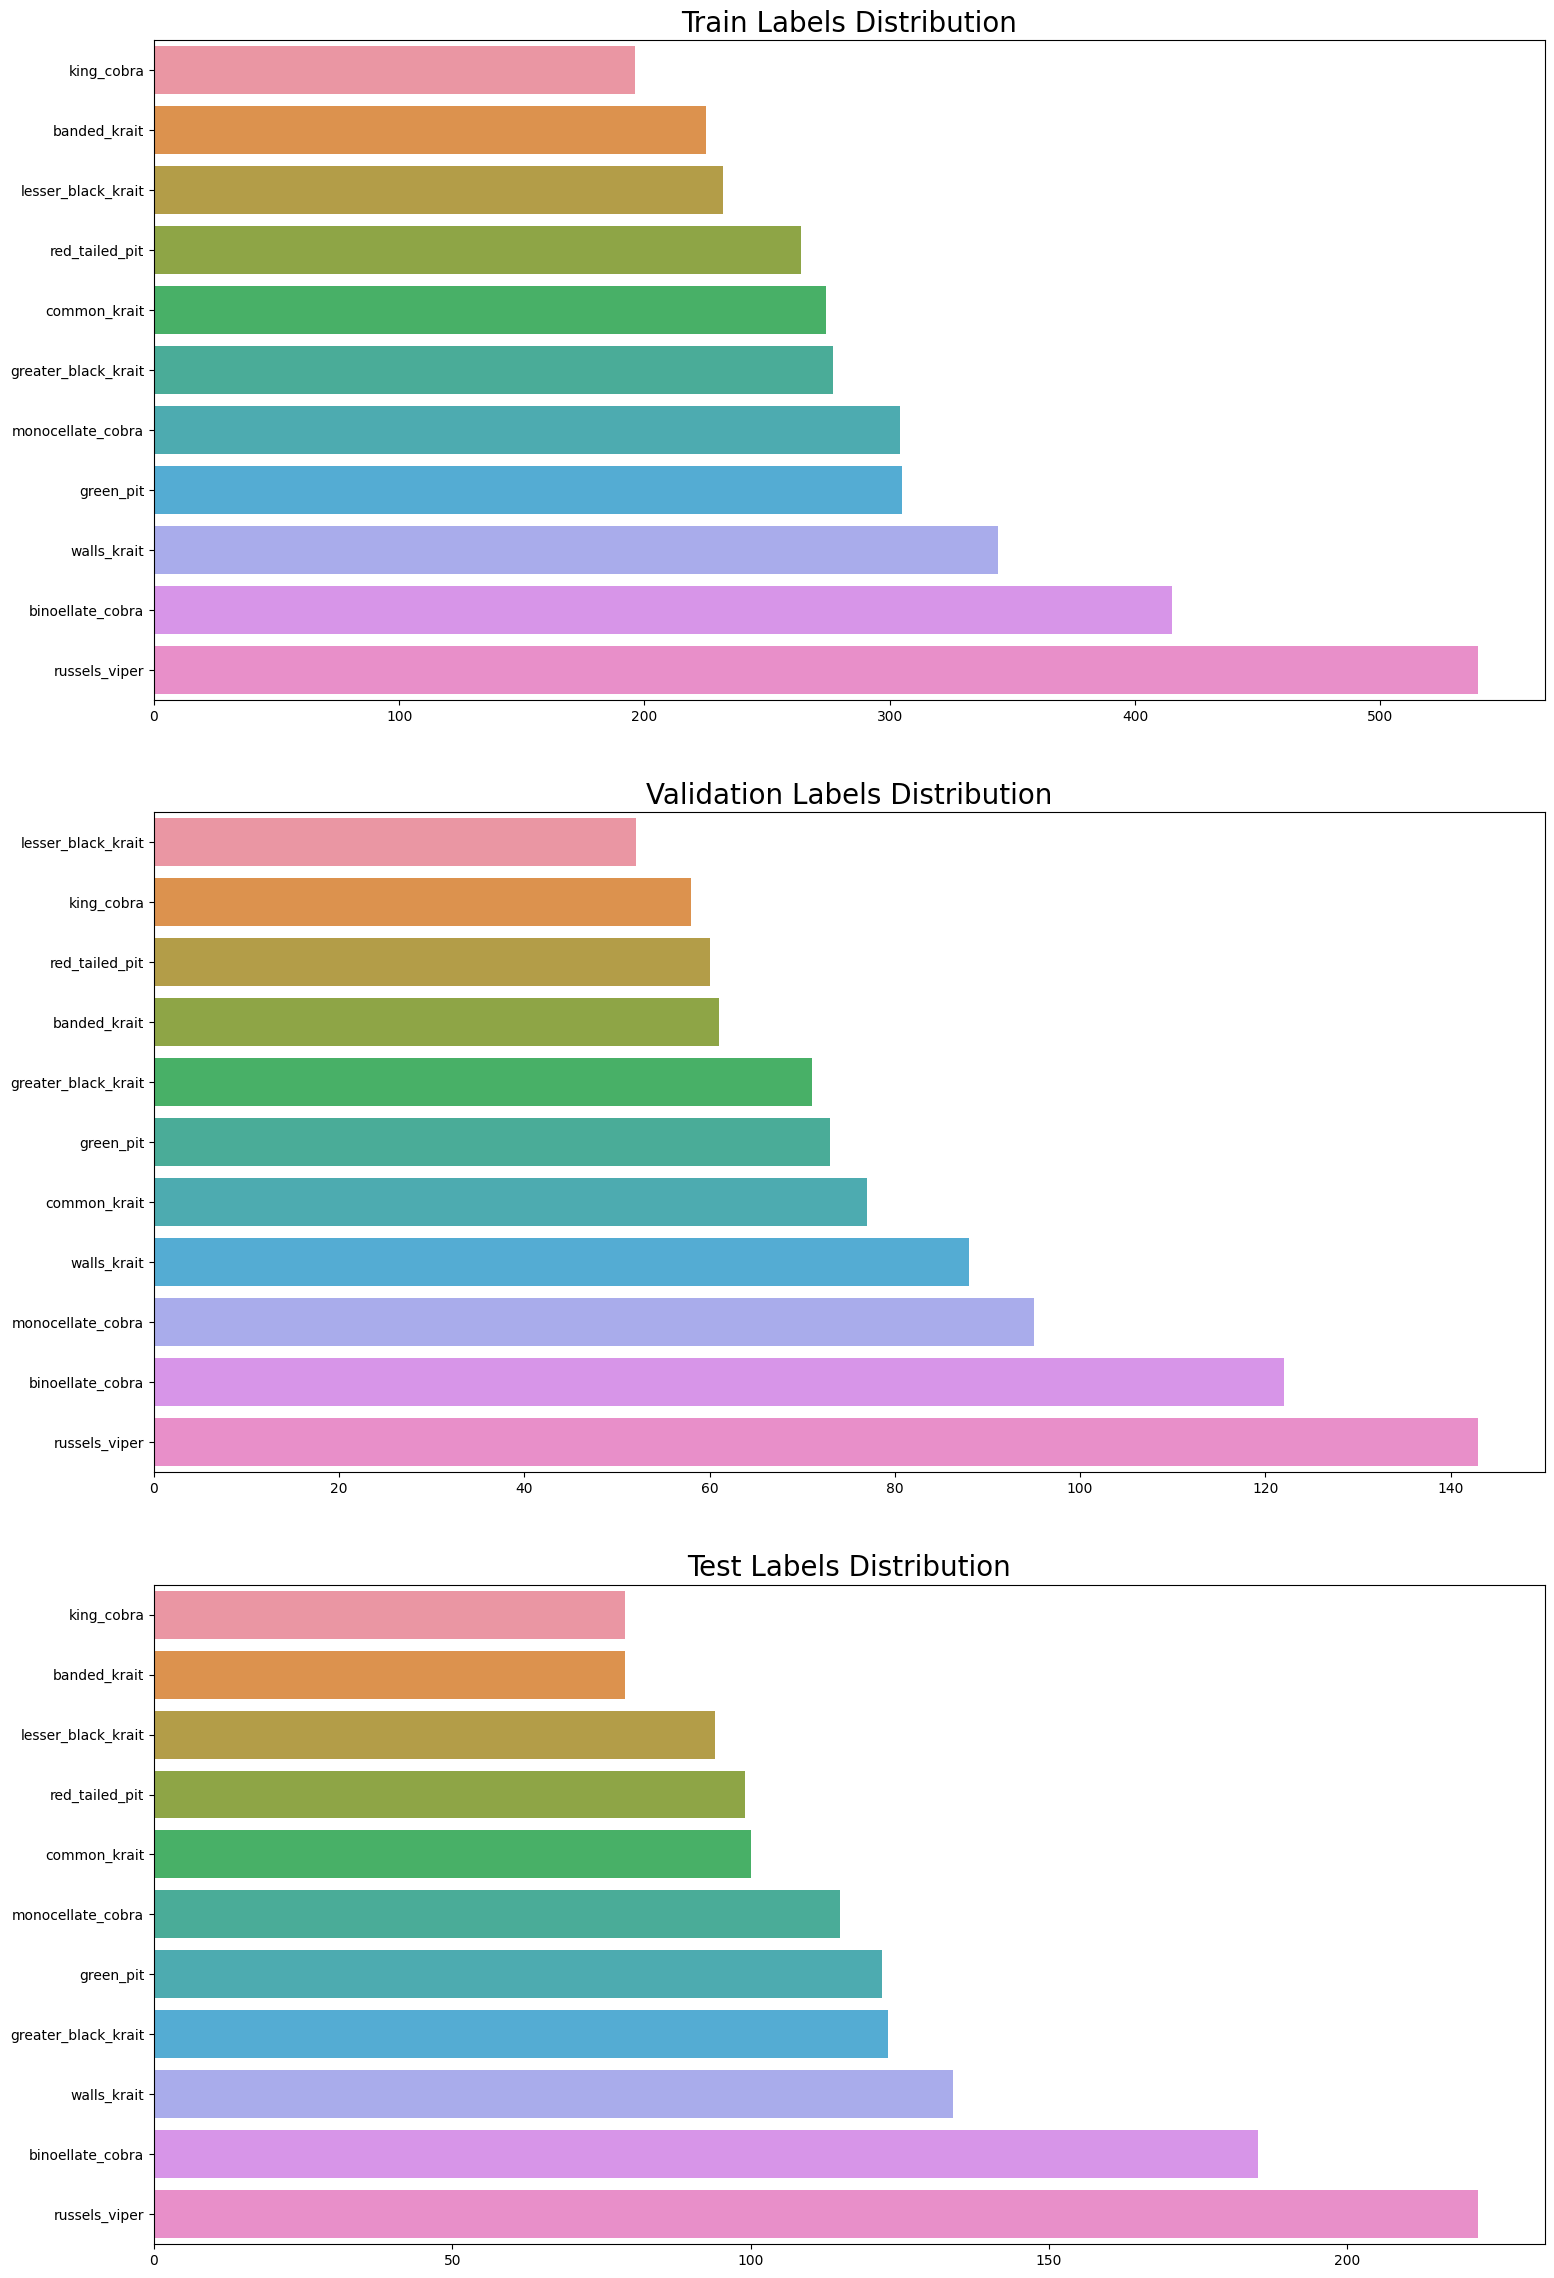

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 24))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

In [24]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
    layers.RandomRotation(factor=0.1, seed=CFG.TF_SEED),
    layers.RandomContrast(factor=0.1, seed=CFG.TF_SEED),

], name='augmentation_layer')

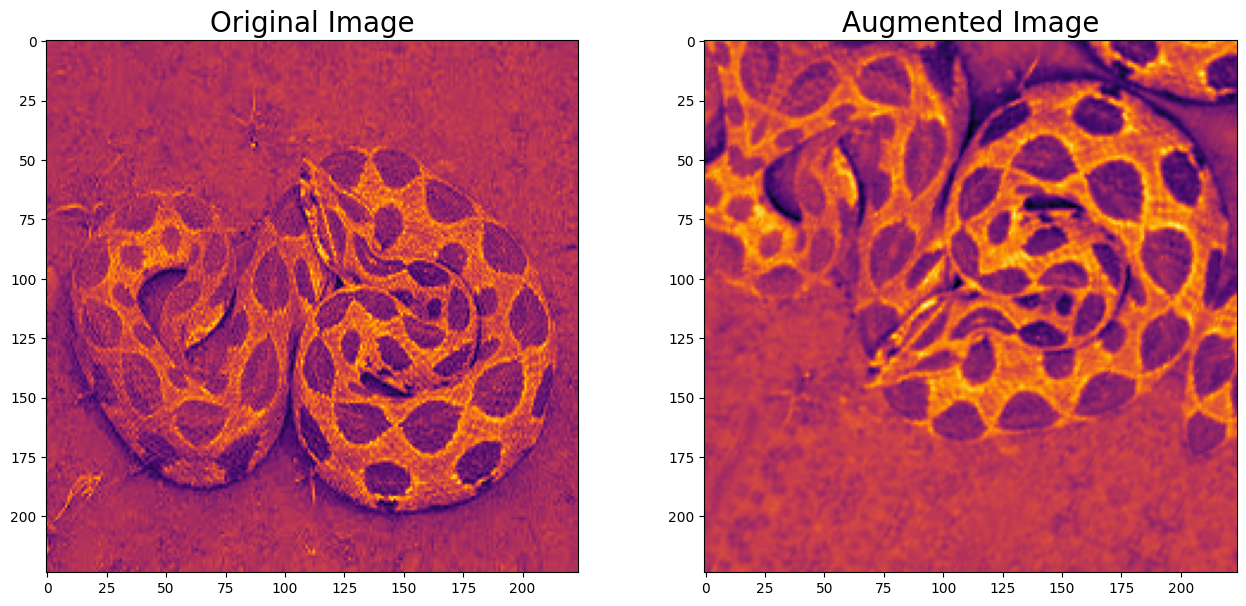

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(tf.image.rgb_to_grayscale(sample_image), cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(tf.image.rgb_to_grayscale(augmentation_layer(sample_image)), cmap='inferno');
plt.savefig(f'/kaggle/working/augmented_image.jpg')

In [26]:
def encode_labels(labels, encode_depth=11):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [27]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_df, _load, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [28]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>


# 3 |Transfer Learning Model:

In [29]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

### Get DenseNet From TensorFlow Hub

In [30]:

def getImgTensor(img_d):
    return (img_d, img_d, 3)
densenet169 = tf.keras.applications.DenseNet169(weights='imagenet', input_shape=getImgTensor(224), include_top=False)
densenet169.trainable = False

model_densenet = tf.keras.models.Sequential([
                             densenet169,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.25),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             tf.keras.layers.Dense(11, activation='softmax')
])
print(model_densenet.summary())

51877672/51877672 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 256)               426240    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                         

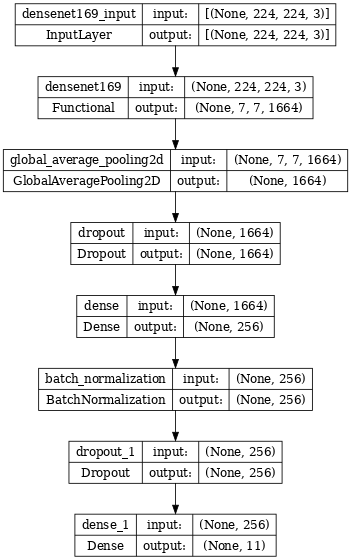

In [31]:
# Explore model visually
plot_model(
    model_densenet, dpi=60,
    show_shapes=True
)

In [32]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, tf_valid_data=None, shuffling=False, model_name="model"):
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
#         model.save(f"/kaggle/working/{model_name}.h5")
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [33]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [34]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_densenet.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_densenet.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

densenet_history = train_model(
    model_densenet, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_densenet"
)

Training sequential.
Train on 3376 samples, validate on 900 samples.
----------------------------------
Epoch 1/20
106/106 [==============================] - 126s 1s/step - loss: 1.4862 - accuracy: 0.5136 - val_loss: 0.9625 - val_accuracy: 0.6433 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 100s 945ms/step - loss: 0.9957 - accuracy: 0.6422 - val_loss: 0.7264 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 101s 956ms/step - loss: 0.8846 - accuracy: 0.6792 - val_loss: 0.6961 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 105s 991ms/step - loss: 0.8368 - accuracy: 0.6834 - val_loss: 0.6372 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 111s 1s/step - loss: 0.8120 - accuracy: 0.6970 - val_loss: 0.6584 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - ETA: 0s - loss: 0.7548 - accuracy: 0.7168
Epoch 6: Re

In [35]:
# Evaluate the model
densenet_evaluation = model_densenet.evaluate(test_ds)

29/43 [===================>..........] - ETA: 8s - loss: 0.4924 - accuracy: 0.8244

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 27s 625ms/step - loss: 0.4892 - accuracy: 0.8210


In [36]:
# Generate model probabilities and associated predictions
densenet_test_probabilities = model_densenet.predict(test_ds, verbose=1)
densenet_test_predictions = tf.argmax(densenet_test_probabilities, axis=1)

29/43 [===================>..........] - ETA: 7s

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 26s 548ms/step


In [37]:
from IPython.display import FileLink
FileLink(r'densenet.h5')

/kaggle/working/densenet.h5

### Get VGG16 From TensorFlow Hub

In [38]:

def getImgTensor(img_d):
    return (img_d, img_d, 3)
vgg16 = tf.keras.applications.VGG16(weights='imagenet', 
                                                input_shape=getImgTensor(224), 
                                                include_top=False)
vgg16.trainable = False

model_vgg16 = tf.keras.models.Sequential([
                             vgg16,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.25),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             tf.keras.layers.Dense(11, activation='softmax')
])
print(model_vgg16.summary())

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                       

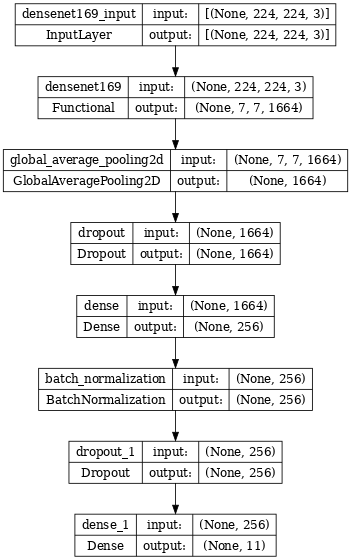

In [39]:
# Explore model visually
plot_model(
    model_densenet, dpi=60,
    show_shapes=True
)

In [40]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vgg16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vgg16.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vgg16_history = train_model(
    model_vgg16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_vgg16"
)

Training sequential_1.
Train on 3376 samples, validate on 900 samples.
----------------------------------
Epoch 1/20
106/106 [==============================] - 110s 990ms/step - loss: 2.3570 - accuracy: 0.2426 - val_loss: 1.8850 - val_accuracy: 0.3956 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 105s 989ms/step - loss: 1.9087 - accuracy: 0.3563 - val_loss: 1.6842 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 104s 986ms/step - loss: 1.7923 - accuracy: 0.3857 - val_loss: 1.5559 - val_accuracy: 0.4889 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 99s 936ms/step - loss: 1.6917 - accuracy: 0.4215 - val_loss: 1.5355 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 100s 946ms/step - loss: 1.6792 - accuracy: 0.4230 - val_loss: 1.5724 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 106s 999ms/step - loss: 1.6451 - accuracy: 0.4

In [41]:
# Evaluate the model
vgg16_evaluation = model_vgg16.evaluate(test_ds)

29/43 [===================>..........] - ETA: 8s - loss: 1.1152 - accuracy: 0.6196

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 24s 562ms/step - loss: 1.2429 - accuracy: 0.6154


In [42]:
# Generate model probabilities and associated predictions
vgg16_test_probabilities = model_vgg16.predict(test_ds, verbose=1)
vgg16_test_predictions = tf.argmax(vgg16_test_probabilities, axis=1)

29/43 [===================>..........] - ETA: 7s

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 23s 536ms/step


In [43]:
from IPython.display import FileLink
FileLink(r'vgg16.h5')

/kaggle/working/vgg16.h5

### Get MobileNet From TensorFlow Hub

In [44]:
# Get mobilenet_v2  here
mobilenet_v2_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
model_name = 'mobilenet_v2'

# Set trainable to False for inference-only 
set_trainable=False

mobilenet_v2 = get_tfhub_model(mobilenet_v2_url, 
                                     model_name, 
                                     model_trainable=set_trainable)

In [45]:
def mobileNet_v2_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    mobileNet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        mobilenet_v2,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(11, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='mobileNet_v2_sequential_model')
    
    return mobileNet_v2_sequential

In [46]:
# Generate Model
model_mobileNet_v2 = mobileNet_v2_model()

# Generate Summary of the Model
model_mobileNet_v2.summary()

Model: "mobileNet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_v2 (KerasLayer)   (None, 1280)              2257984   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 11)                2827      
                                                                 
Total params: 3,048,011
Trainable params: 790,027
Non-trainable params: 2,257,984
_________________________________________________________________


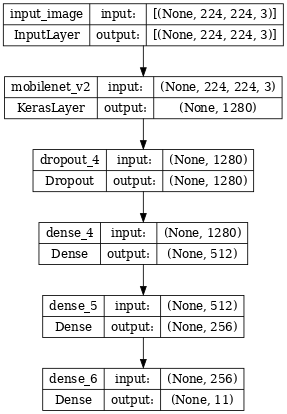

In [47]:
# Explore model visually
plot_model(
    model_mobileNet_v2, dpi=60,
    show_shapes=True
)

In [48]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_mobileNet_v2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_mobileNet_v2.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

mobilenet_v2_history = train_model(
    model_mobileNet_v2, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_mobilenet"
)

Training mobileNet_v2_sequential_model.
Train on 3376 samples, validate on 900 samples.
----------------------------------
Epoch 1/20
106/106 [==============================] - 101s 909ms/step - loss: 1.1430 - accuracy: 0.5868 - val_loss: 0.8328 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 101s 959ms/step - loss: 0.7874 - accuracy: 0.6955 - val_loss: 0.7520 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 95s 901ms/step - loss: 0.6864 - accuracy: 0.7322 - val_loss: 0.7839 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 102s 963ms/step - loss: 0.6219 - accuracy: 0.7488 - val_loss: 0.7307 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 101s 952ms/step - loss: 0.5872 - accuracy: 0.7722 - val_loss: 0.6685 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 95s 901ms/step - loss: 0.5281

In [49]:
# Evaluate the model
mobileNet_v2_evaluation = model_mobileNet_v2.evaluate(test_ds)

29/43 [===================>..........] - ETA: 8s - loss: 0.4690 - accuracy: 0.8179

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 23s 549ms/step - loss: 0.4525 - accuracy: 0.8232


In [50]:
# Generate model probabilities and associated predictions
mobilenet_v2_test_probabilities = model_mobileNet_v2.predict(test_ds, verbose=1)
mobilenet_v2_test_predictions = tf.argmax(mobilenet_v2_test_probabilities, axis=1)

29/43 [===================>..........] - ETA: 7s

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 29s 544ms/step


In [51]:
from IPython.display import FileLink
FileLink(r'mobilenet.h5')

/kaggle/working/mobilenet.h5

### Get ResNet From TensorFlow Hub

In [52]:
# Get resnet_v2  here
resnet_url = 'https://tfhub.dev/sayakpaul/bit_r152x2_224_feature_extraction/1'
model_name = 'resnet_v2'

# Set trainable to False for inference-only 
set_trainable=False

resnet_152 = get_tfhub_model(resnet_url, 
                                     model_name, 
                                     model_trainable=set_trainable)

In [53]:
def resnet_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    resnet_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        resnet_152,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(11, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='resnet_sequential_model')
    
    return resnet_sequential

In [54]:
# Generate Model
model_resnet = resnet_model()

# Generate Summary of the Model
model_resnet.summary()

Model: "resnet_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_v2 (KerasLayer)      (None, 4096)              232238208 
                                                                 
 dropout_5 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               2097664   
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 11)                2827      
                                                                 
Total params: 234,470,027
Trainable params: 2,231,819
Non-trainable params: 232,238,208
_________________________________________________________________


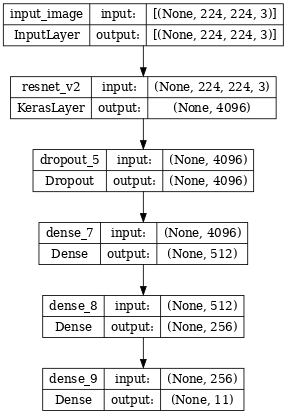

In [55]:
# Explore model visually
plot_model(
    model_resnet, dpi=60,
    show_shapes=True
)

In [56]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_resnet.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_resnet.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

resnet_history = train_model(
    model_resnet, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name= "h5_resnet"
)

Training resnet_sequential_model.
Train on 3376 samples, validate on 900 samples.
----------------------------------
Epoch 1/20
106/106 [==============================] - 228s 2s/step - loss: 1.5511 - accuracy: 0.5418 - val_loss: 0.7193 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 181s 2s/step - loss: 0.7313 - accuracy: 0.7192 - val_loss: 0.6155 - val_accuracy: 0.7522 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 163s 2s/step - loss: 0.5935 - accuracy: 0.7672 - val_loss: 0.5809 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 162s 2s/step - loss: 0.5709 - accuracy: 0.7725 - val_loss: 0.5206 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 181s 2s/step - loss: 0.5307 - accuracy: 0.7956 - val_loss: 0.4812 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 163s 2s/step - loss: 0.5051 - accuracy: 0.8042 - 

In [57]:
# Evaluate the model
resnet_evaluation = model_resnet.evaluate(test_ds)

28/43 [==================>...........] - ETA: 11s - loss: 0.4022 - accuracy: 0.8225

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 33s 759ms/step - loss: 0.4061 - accuracy: 0.8321


In [58]:
# Generate model probabilities and associated predictions
resnet_test_probabilities = model_resnet.predict(test_ds, verbose=1)
resnet_test_predictions = tf.argmax(resnet_test_probabilities, axis=1)

28/43 [==================>...........] - ETA: 12s

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 78s 815ms/step


In [59]:
from IPython.display import FileLink
FileLink(r'resnet.h5')

/kaggle/working/resnet.h5

### Transfer Learning Model: Vision Transformer

In [60]:
!pip install -q vit-keras

In [61]:
from vit_keras import vit

# Download the model
vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=11)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 17s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [62]:
def vit_b16_model():
    
    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)
    
    vit_b16_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(11, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

In [63]:
# Generate Model
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_6 (Dropout)         (None, 768)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               393728    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 11)                2827      
                                                                 
Total params: 86,326,539
Trainable params: 527,883
Non-trainable params: 85,798,656
_________________________________________________________________


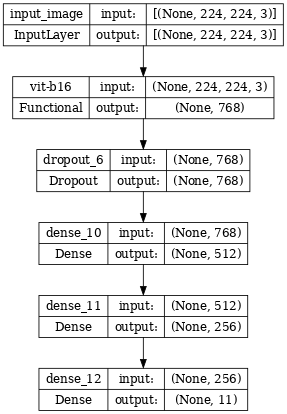

In [64]:
# Explore model visually
plot_model(
    model_vit_b16, dpi=60,
    show_shapes=True
)

In [65]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model 
print(f'Training {model_vit_b16.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

vit_b16_history = train_model(
    model_vit_b16, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False,
    model_name = "h5_vit"
)

Training vit_b16_sequential_model.
Train on 3376 samples, validate on 900 samples.
----------------------------------
Epoch 1/20
106/106 [==============================] - 118s 995ms/step - loss: 1.1738 - accuracy: 0.5678 - val_loss: 0.8468 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 107s 1s/step - loss: 0.8068 - accuracy: 0.6878 - val_loss: 0.6934 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 106s 998ms/step - loss: 0.7261 - accuracy: 0.7263 - val_loss: 0.6819 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 103s 975ms/step - loss: 0.6340 - accuracy: 0.7494 - val_loss: 0.6751 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 106s 1s/step - loss: 0.6079 - accuracy: 0.7621 - val_loss: 0.6257 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 102s 963ms/step - loss: 0.5595 - accura

In [66]:
# Evaluate the model
vit_b16_evaluation = model_vit_b16.evaluate(test_ds)

29/43 [===================>..........] - ETA: 8s - loss: 0.4637 - accuracy: 0.8082

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 25s 588ms/step - loss: 0.4429 - accuracy: 0.8136


In [67]:
# Generate model probabilities and associated predictions
vit_b16_test_probabilities = model_vit_b16.predict(test_ds, verbose=1)
vit_b16_test_predictions = tf.argmax(vit_b16_test_probabilities, axis=1)

29/43 [===================>..........] - ETA: 8s

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


43/43 [==============================] - 83s 578ms/step


In [68]:
from IPython.display import FileLink
FileLink(r'vit.h5')

/kaggle/working/vit.h5

### Ensemble via Averaging

In [69]:
# Compute average probabilities
avg_probabilities = np.mean([
    densenet_test_probabilities, 
    vgg16_test_probabilities, 
    mobilenet_v2_test_probabilities, 
    resnet_test_probabilities, 
    vit_b16_test_probabilities], axis=0)

# Compute average ensemble predictions
avg_predictions = tf.argmax(avg_probabilities, axis=1)

In [70]:
# Define weights and list model probabilities
weights = [0.15, 0.1, 0.25, 0.3, 0.2]
model_probabilities = [densenet_test_probabilities,
                       vgg16_test_probabilities,
                       mobilenet_v2_test_probabilities, 
                       resnet_test_probabilities, 
                       vit_b16_test_probabilities]

# Compute weighted average probabilities
weighted_avg_probabilities = sum([w * p for w, p in zip(weights, model_probabilities)])

# Compute weighted average ensemble predictions
weighted_avg_predictions = tf.argmax(weighted_avg_probabilities, axis=1)

In [71]:
# List model probabilities
model_probabilities = [densenet_test_probabilities, 
                       vgg16_test_probabilities, 
                       mobilenet_v2_test_probabilities, 
                       resnet_test_probabilities, 
                       vit_b16_test_probabilities]

# Compute geometric mean probabilities
geometric_mean_probabilities = np.power(np.multiply(np.multiply(model_probabilities[0], 
                                                    model_probabilities[1]),
                                        np.multiply(model_probabilities[2], 
                                                    model_probabilities[3], 
                                                    model_probabilities[4])),
                                        1/len(model_probabilities))

# Compute weighted average ensemble predictions
geometric_mean_predictions = tf.argmax(geometric_mean_probabilities, axis=1)

### Performance Evaluation

In [72]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

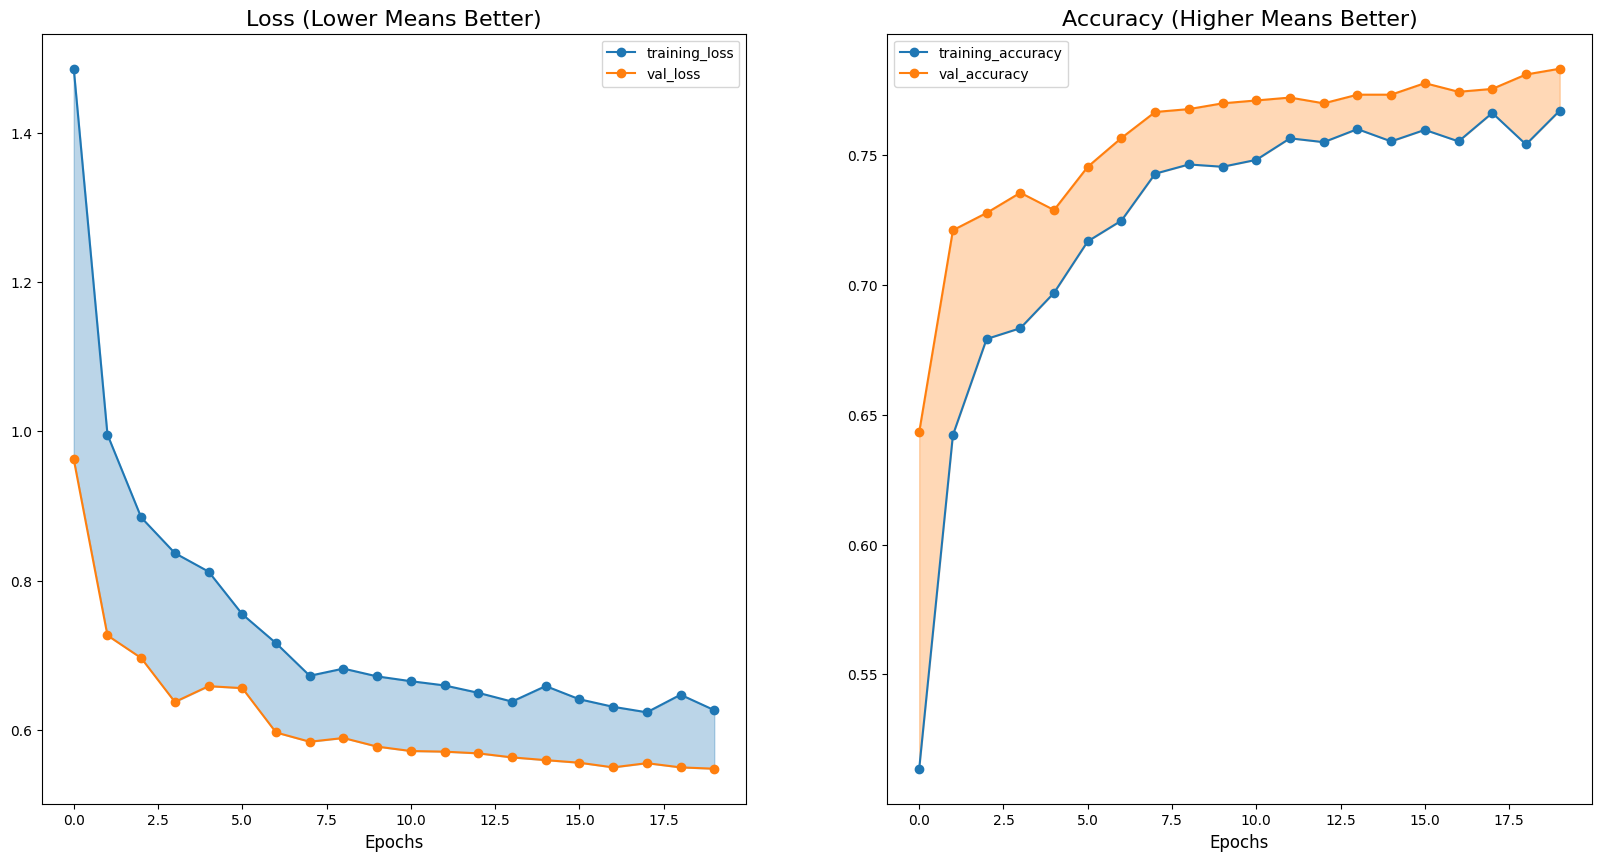

In [73]:
# Plot Densenet model training history 
plot_training_curves(densenet_history)


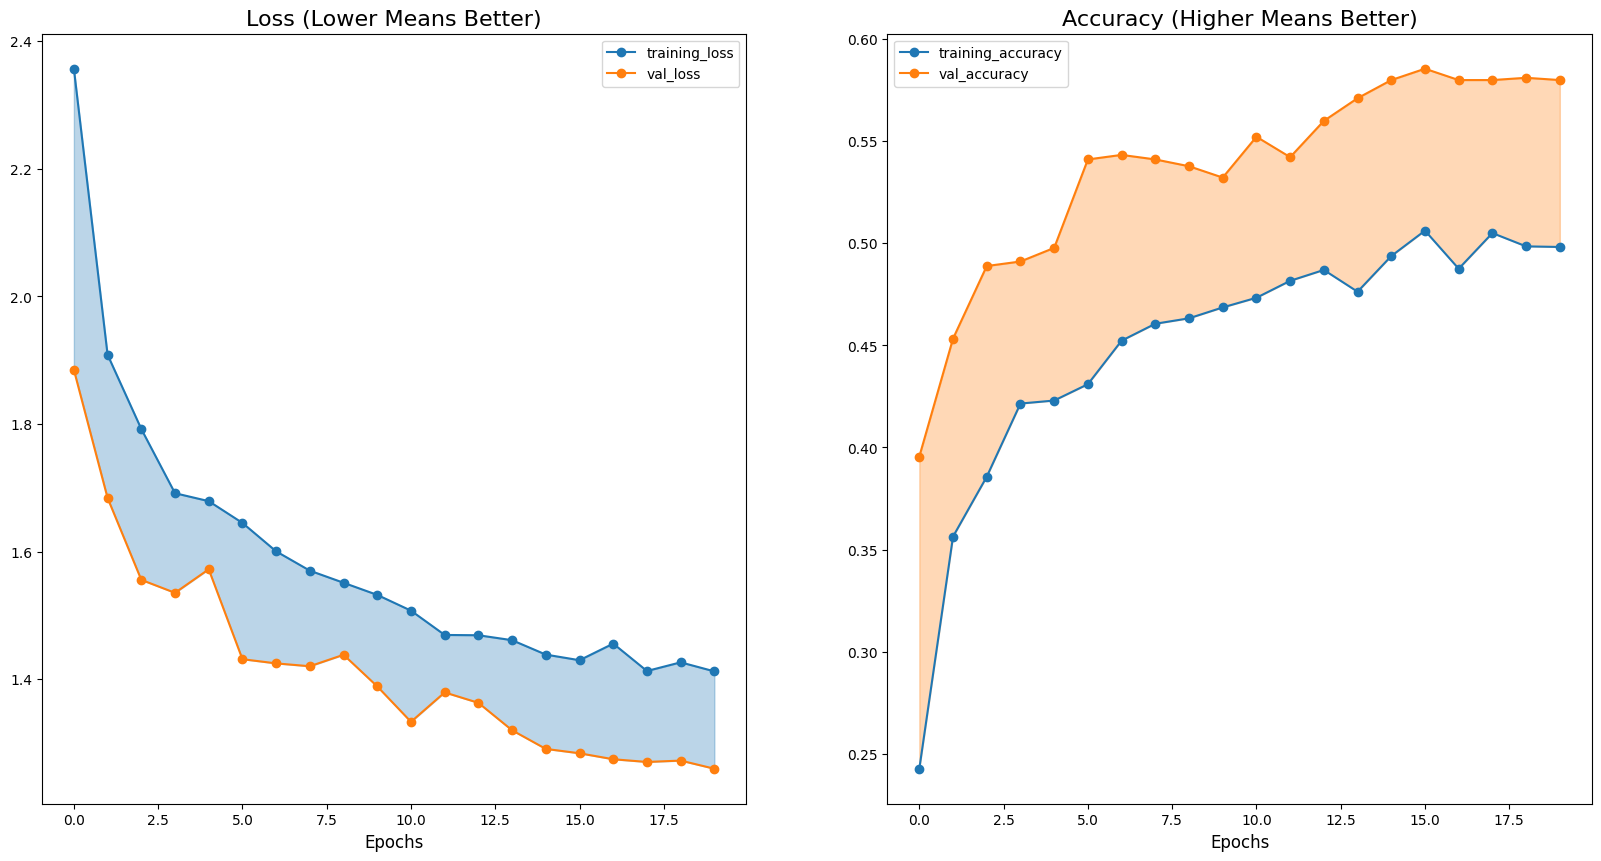

In [74]:
# Plot Vgg16 model training history 
plot_training_curves(vgg16_history)
plt.savefig(f'/kaggle/working/vgg16_graph.jpg')

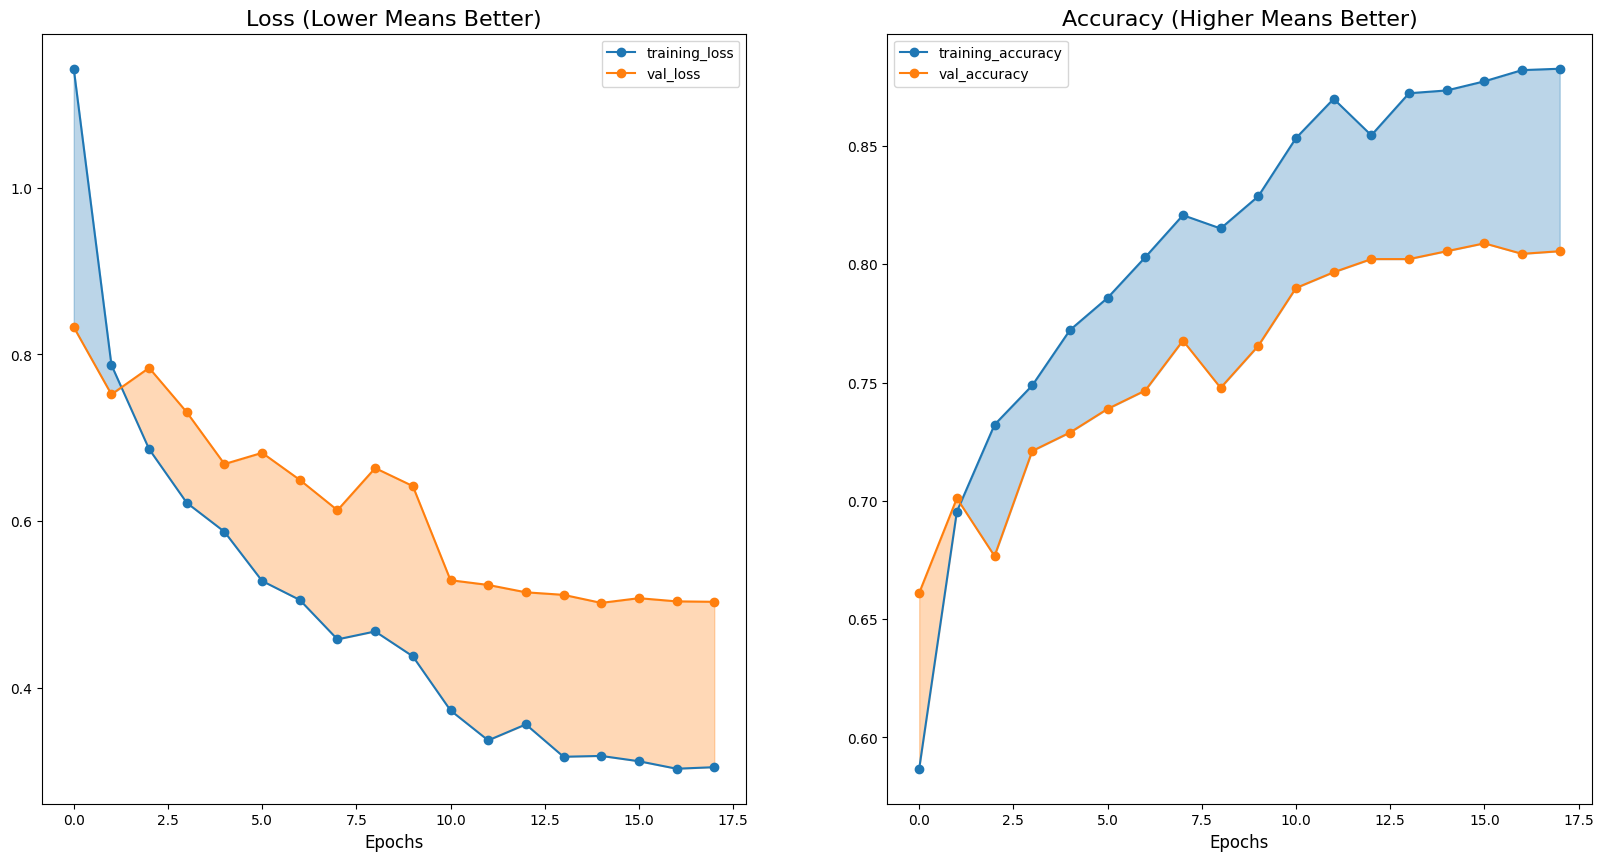

In [75]:
# Plot Mobilenet V2 model training history 
plot_training_curves(mobilenet_v2_history)
plt.savefig(f'/kaggle/working/mobilenet_graph.jpg')

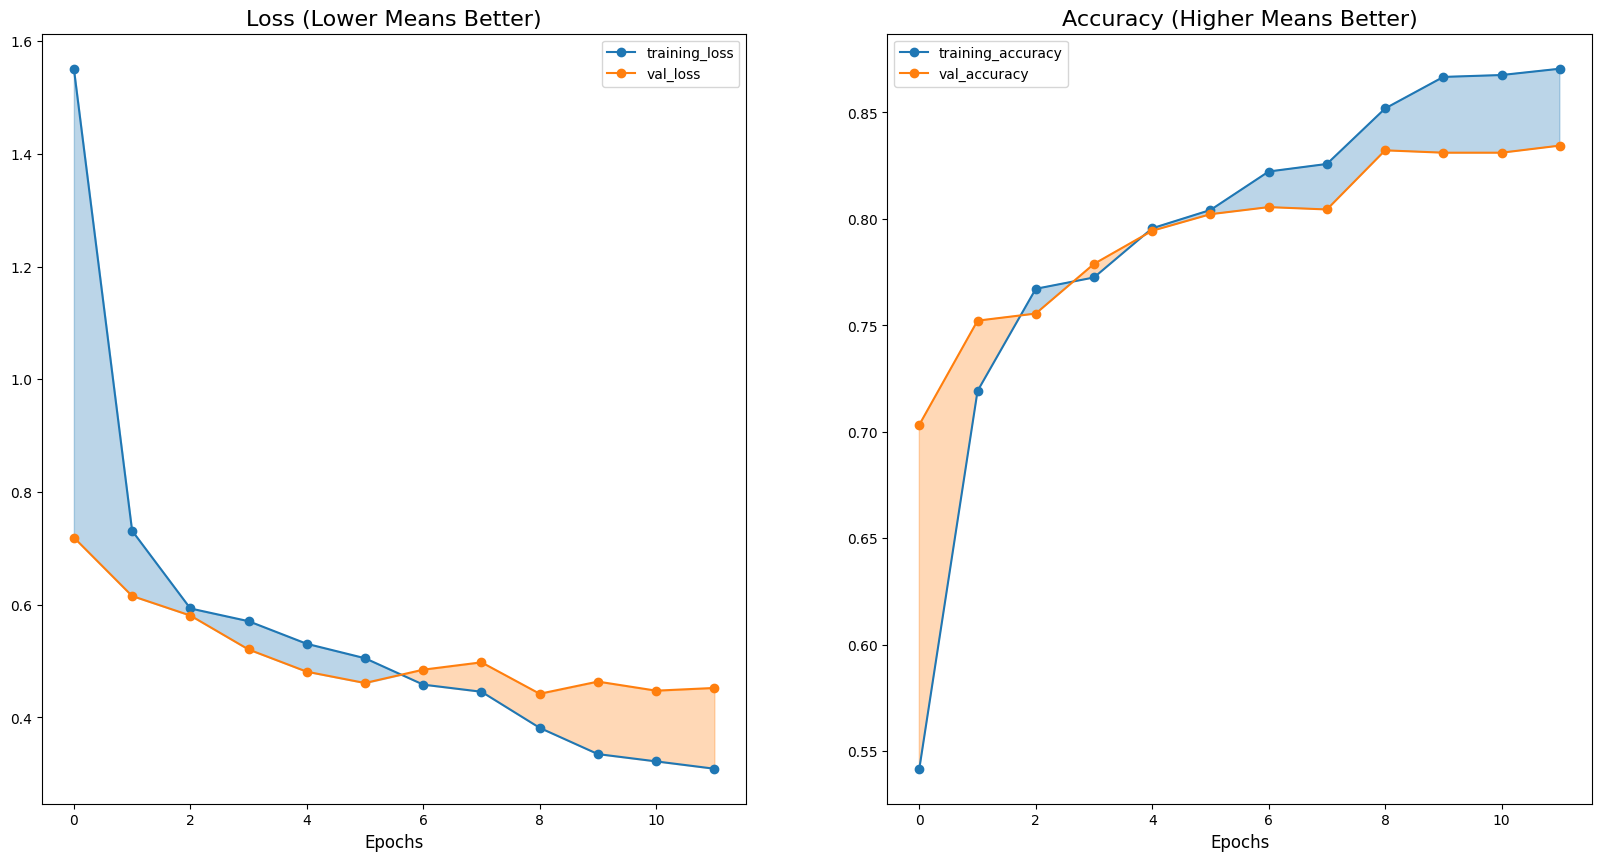

In [76]:
# Plot EfficientNet V2 B0 model training history 
plot_training_curves(resnet_history)
plt.savefig(f'/kaggle/working/resnet_graph.jpg')

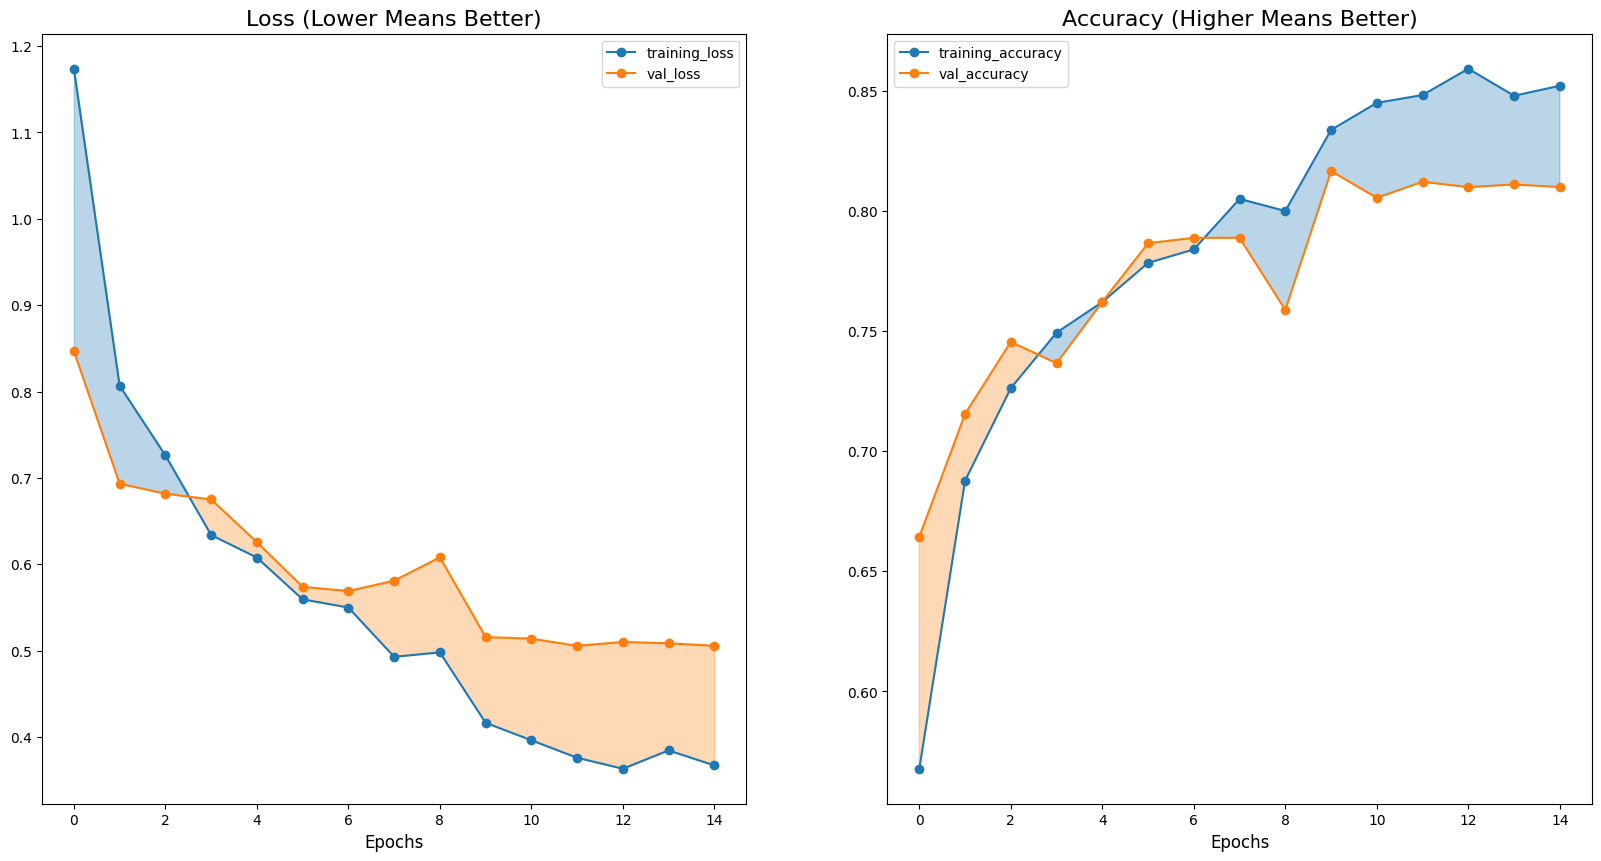

In [77]:
# Plot VIT B16 model training history 
plot_training_curves(vit_b16_history)
plt.savefig(f'/kaggle/working/vit_graph.jpg')

### Plot Confusion Matrix

In [78]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    plt.savefig(f'/kaggle/working/plot_confussion_densenet.jpg')
    
    
    return

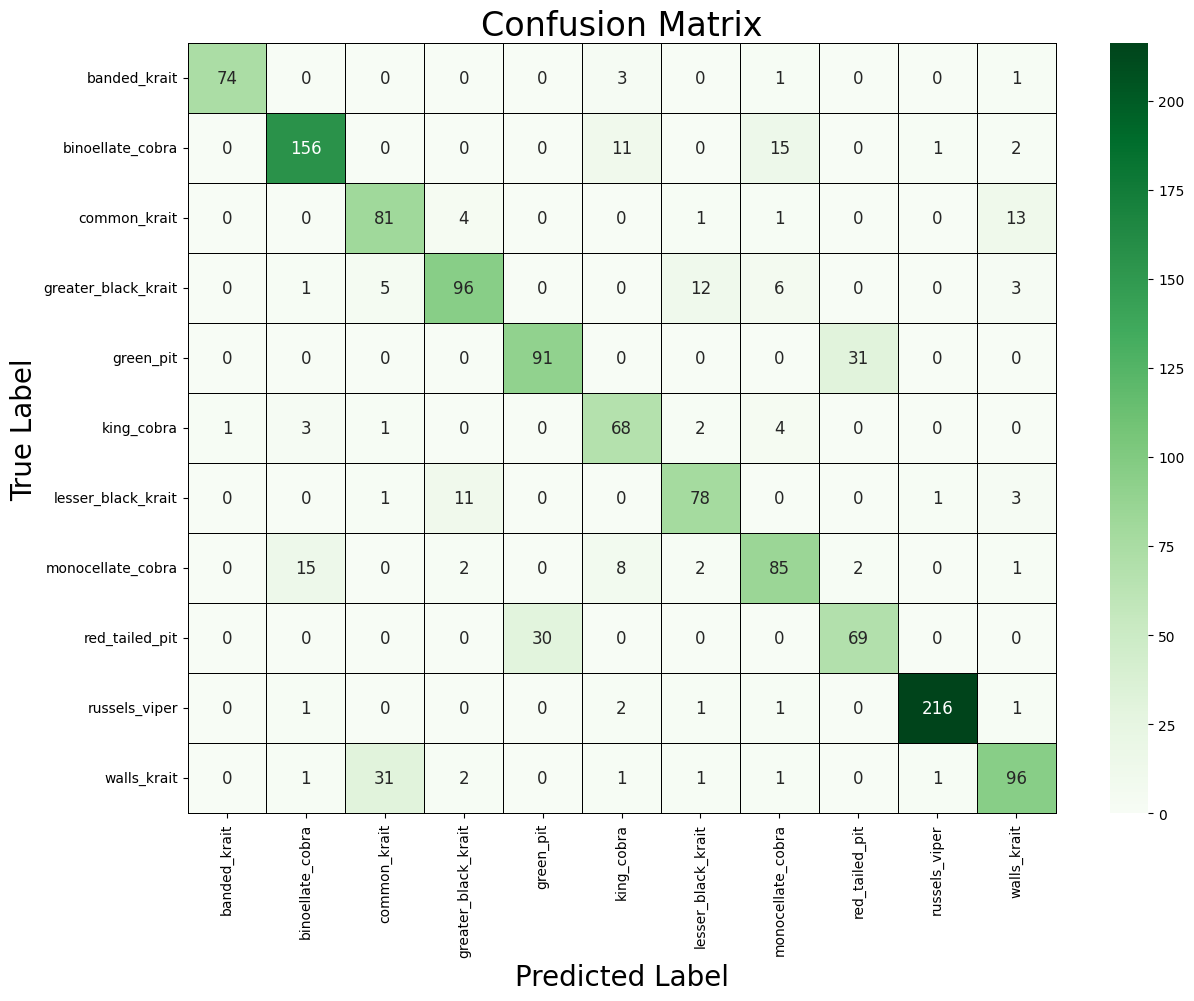

<Figure size 640x480 with 0 Axes>

In [79]:
plot_confusion_matrix(
    test_df.label_encoded, 
    densenet_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)


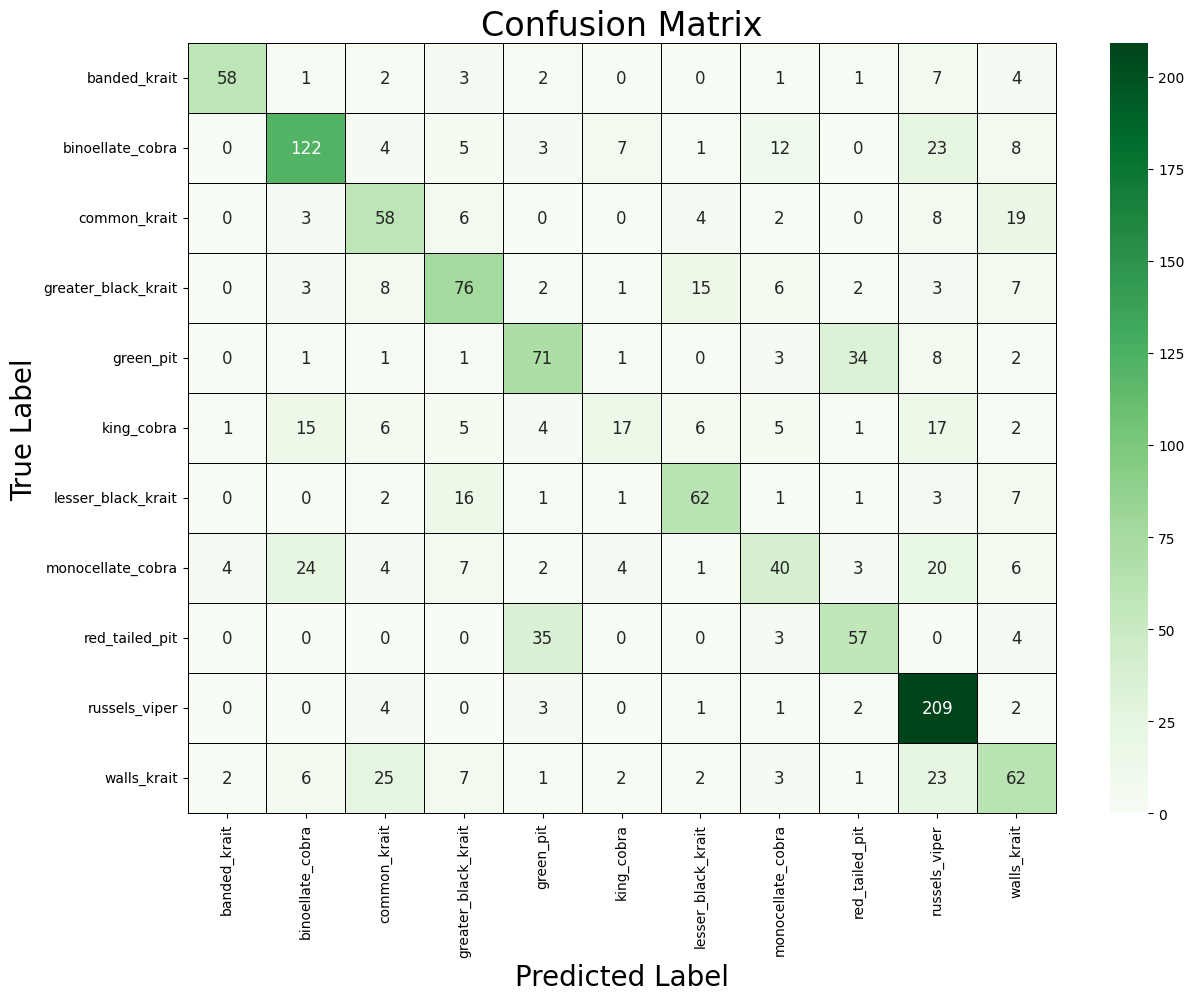

<Figure size 640x480 with 0 Axes>

In [80]:
plot_confusion_matrix(
    test_df.label_encoded, 
    vgg16_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)
plt.savefig(f'/kaggle/working/vgg16_confusion_matrix.jpg')

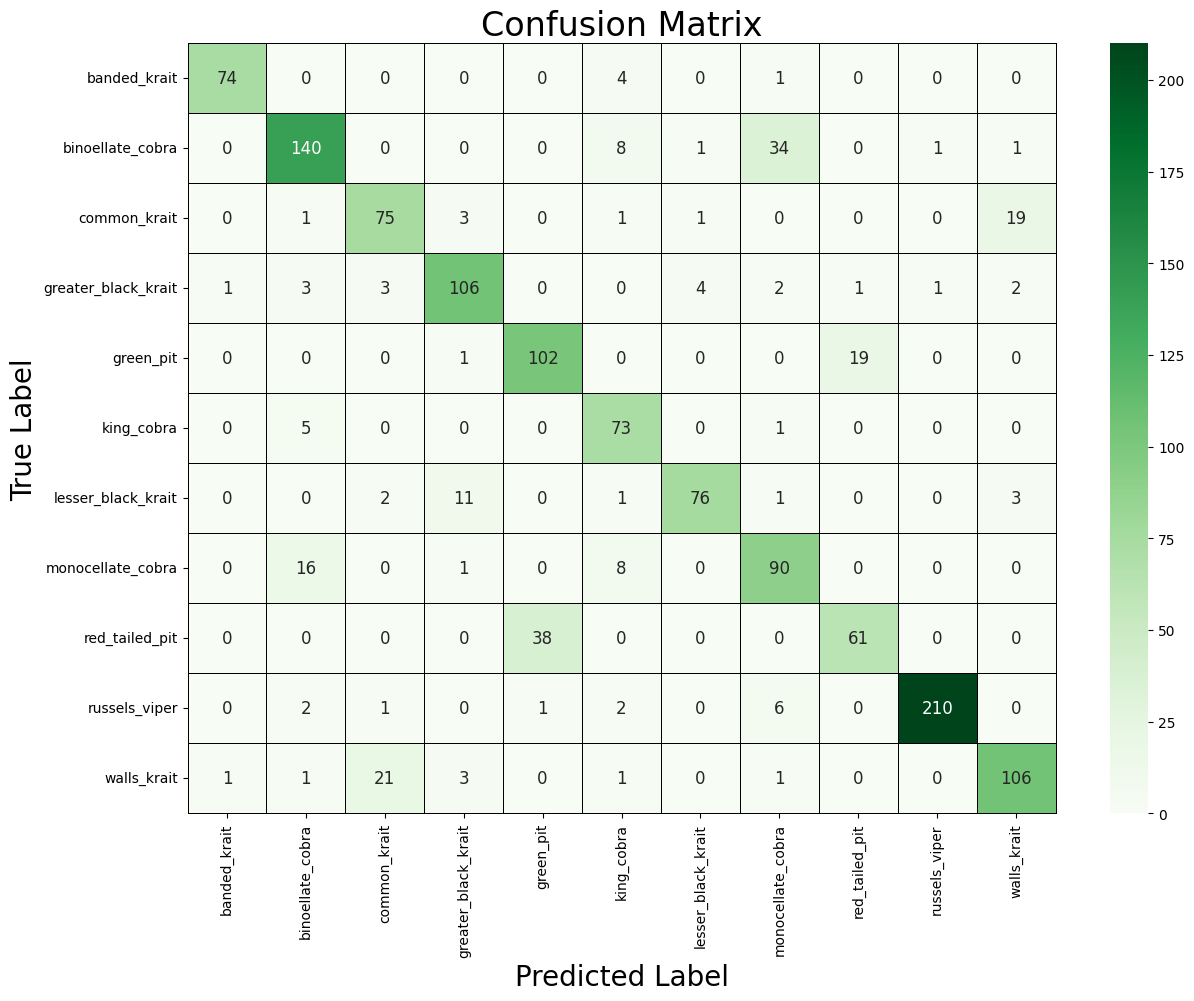

<Figure size 640x480 with 0 Axes>

In [81]:
plot_confusion_matrix(
    test_df.label_encoded, 
    mobilenet_v2_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)
plt.savefig(f'/kaggle/working/mobilenet_confusion_matrix.jpg')

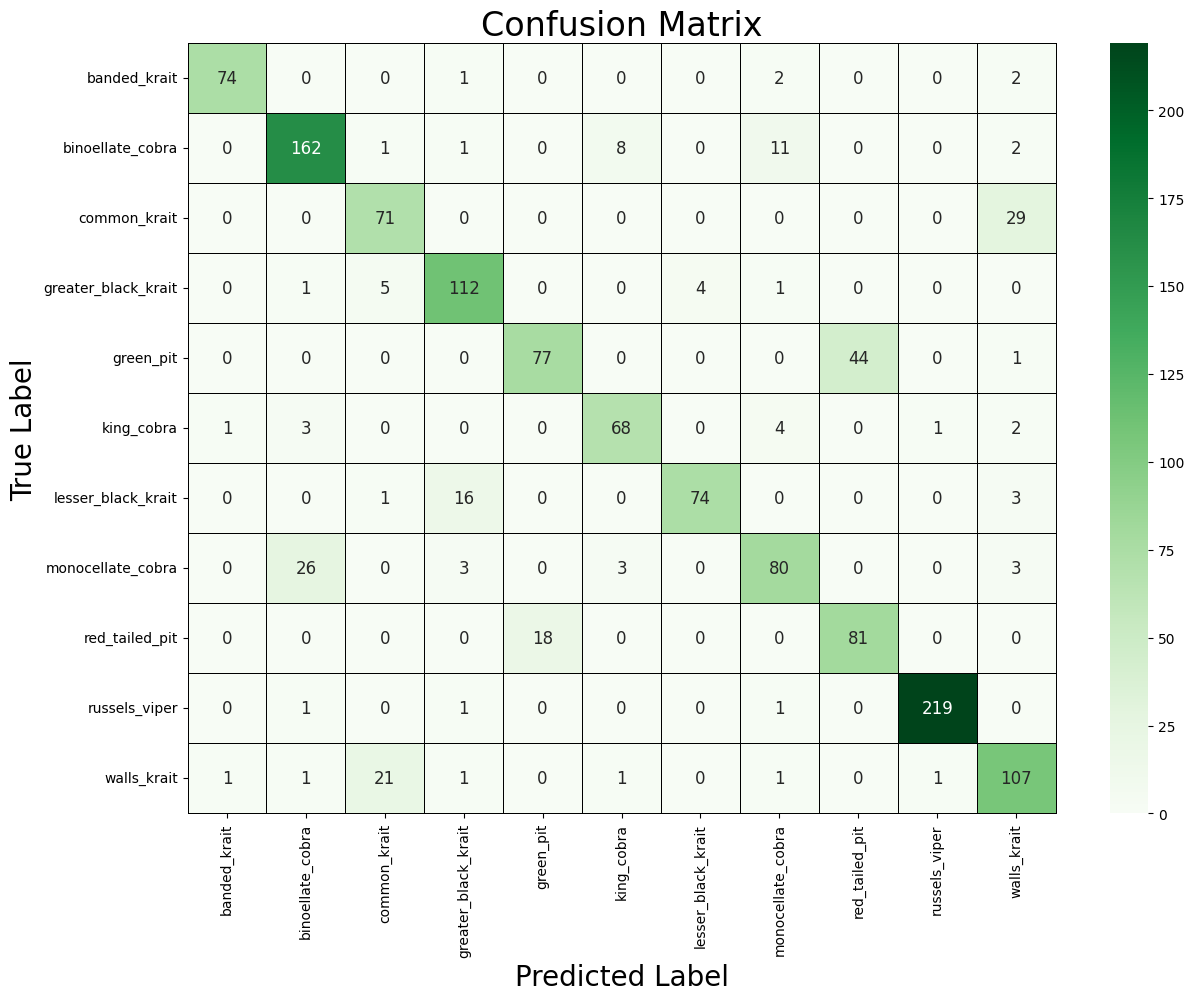

<Figure size 640x480 with 0 Axes>

In [82]:
plot_confusion_matrix(
    test_df.label_encoded, 
    resnet_test_predictions, 
    figsize=(14, 10),  
    classes=class_names)
plt.savefig(f'/kaggle/working/resnet_confusion_matrix.jpg')

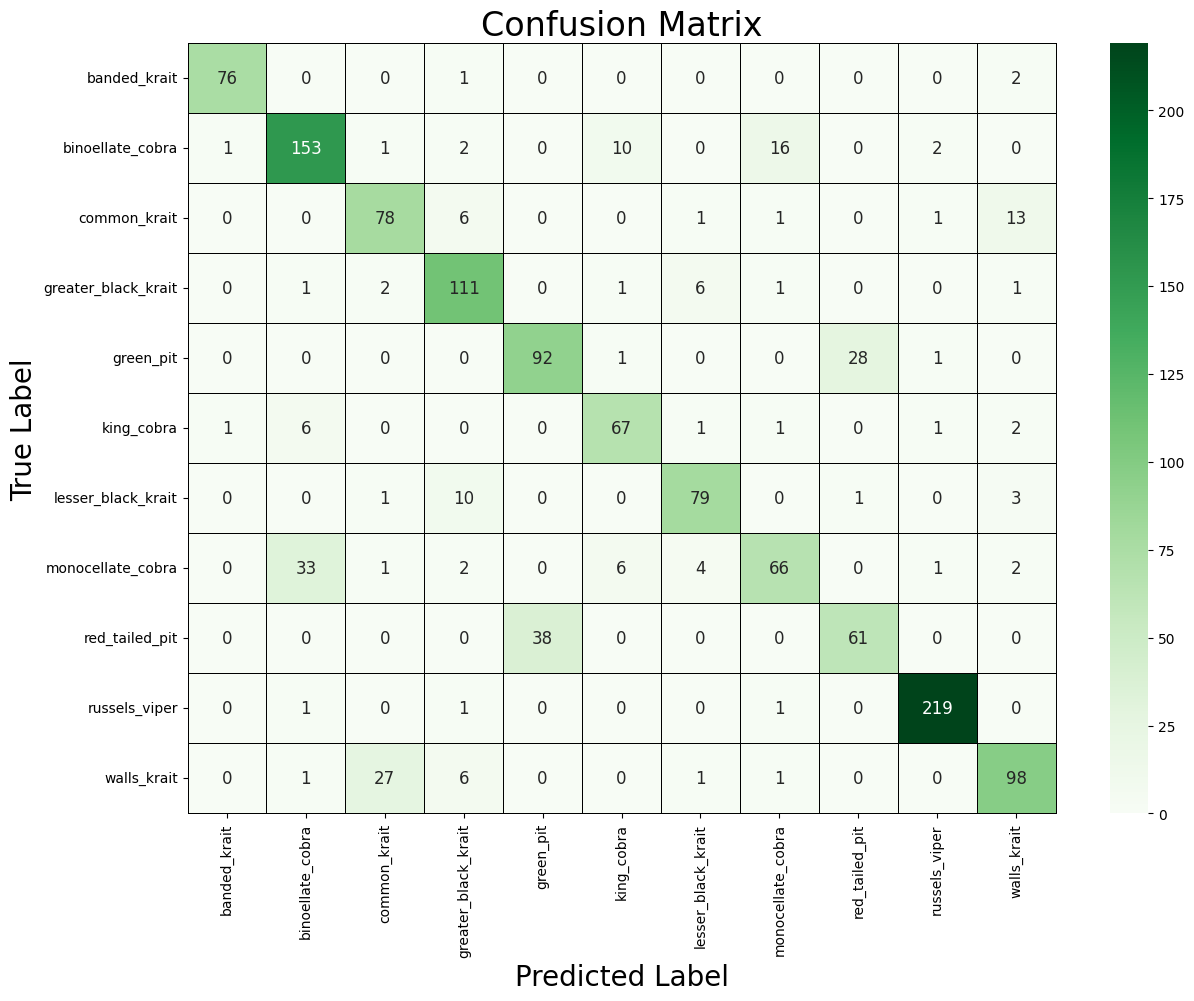

<Figure size 640x480 with 0 Axes>

In [83]:
plot_confusion_matrix(
    test_df.label_encoded, 
    vit_b16_test_predictions, 
    figsize=(14, 10), 
    classes=class_names)
plt.savefig(f'/kaggle/working/vit_confusion_matrix.jpg')

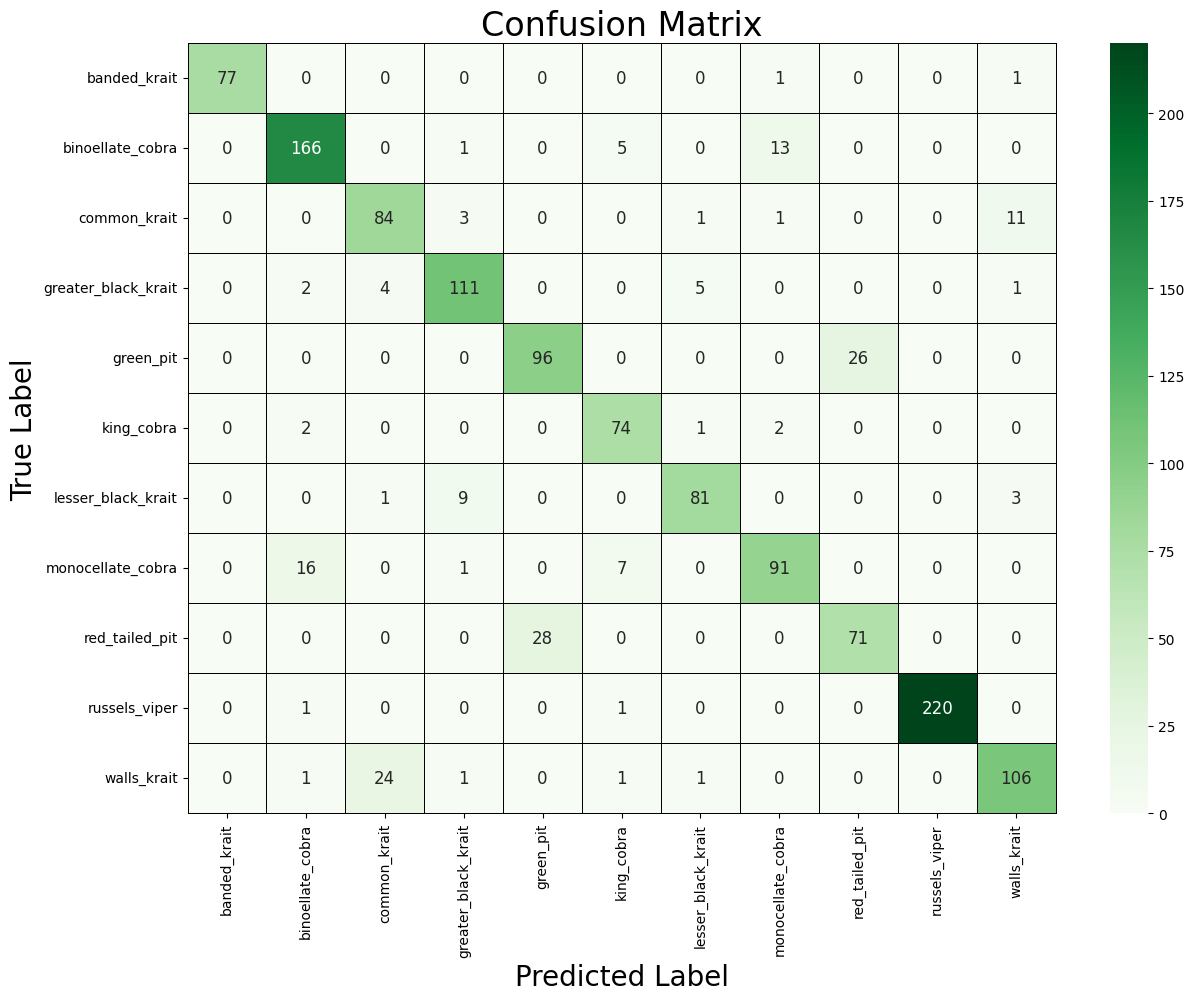

<Figure size 640x480 with 0 Axes>

In [84]:
plot_confusion_matrix(
    test_df.label_encoded, 
    avg_predictions, 
    figsize=(14, 10), 
    classes=class_names)
plt.savefig(f'/kaggle/working/avg_confusion_matrix.jpg')

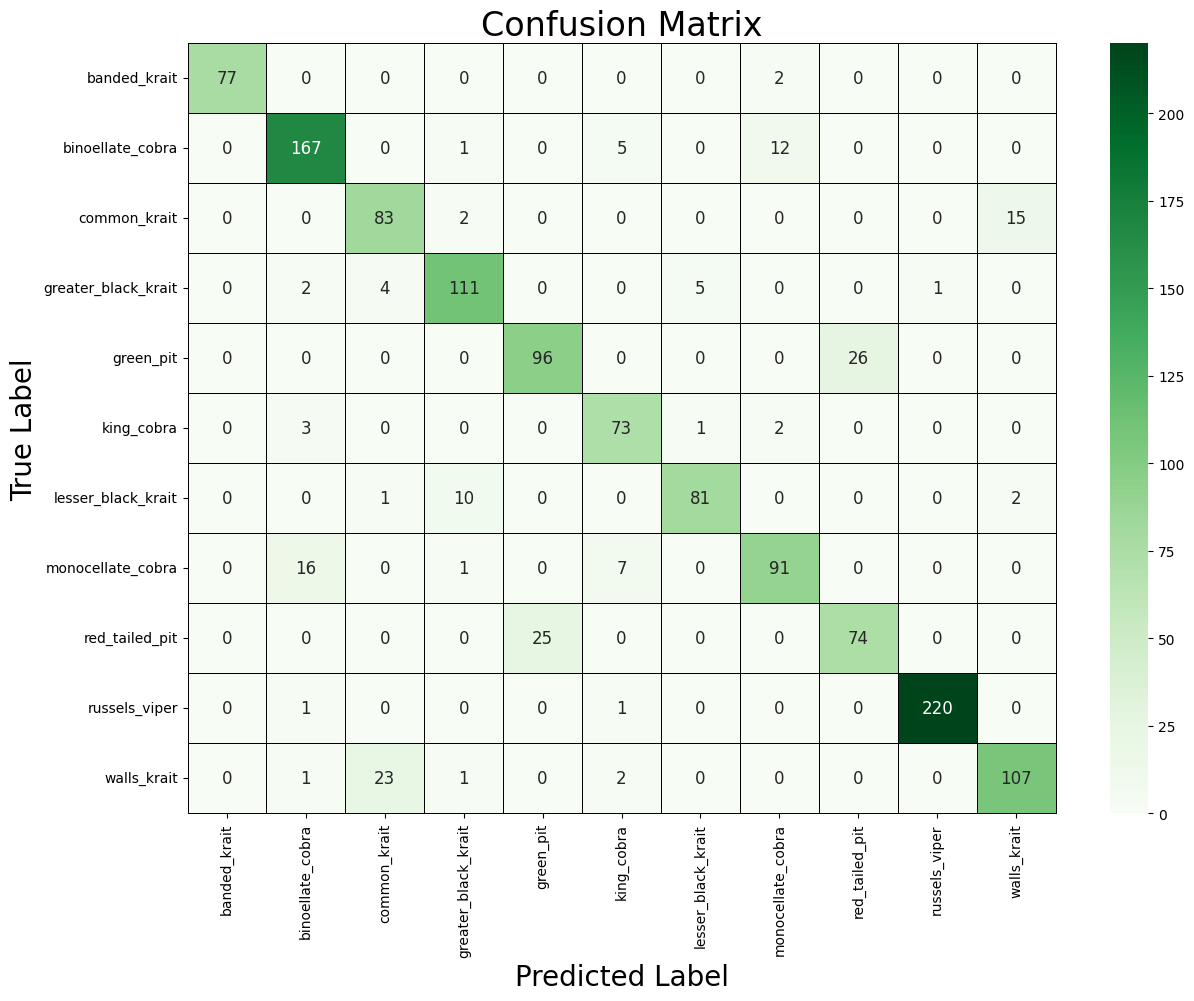

<Figure size 640x480 with 0 Axes>

In [85]:
plot_confusion_matrix(
    test_df.label_encoded, 
    weighted_avg_predictions, 
    figsize=(14, 10), 
    classes=class_names)

plt.savefig(f'/kaggle/working/weight_confusion_matrix.jpg')

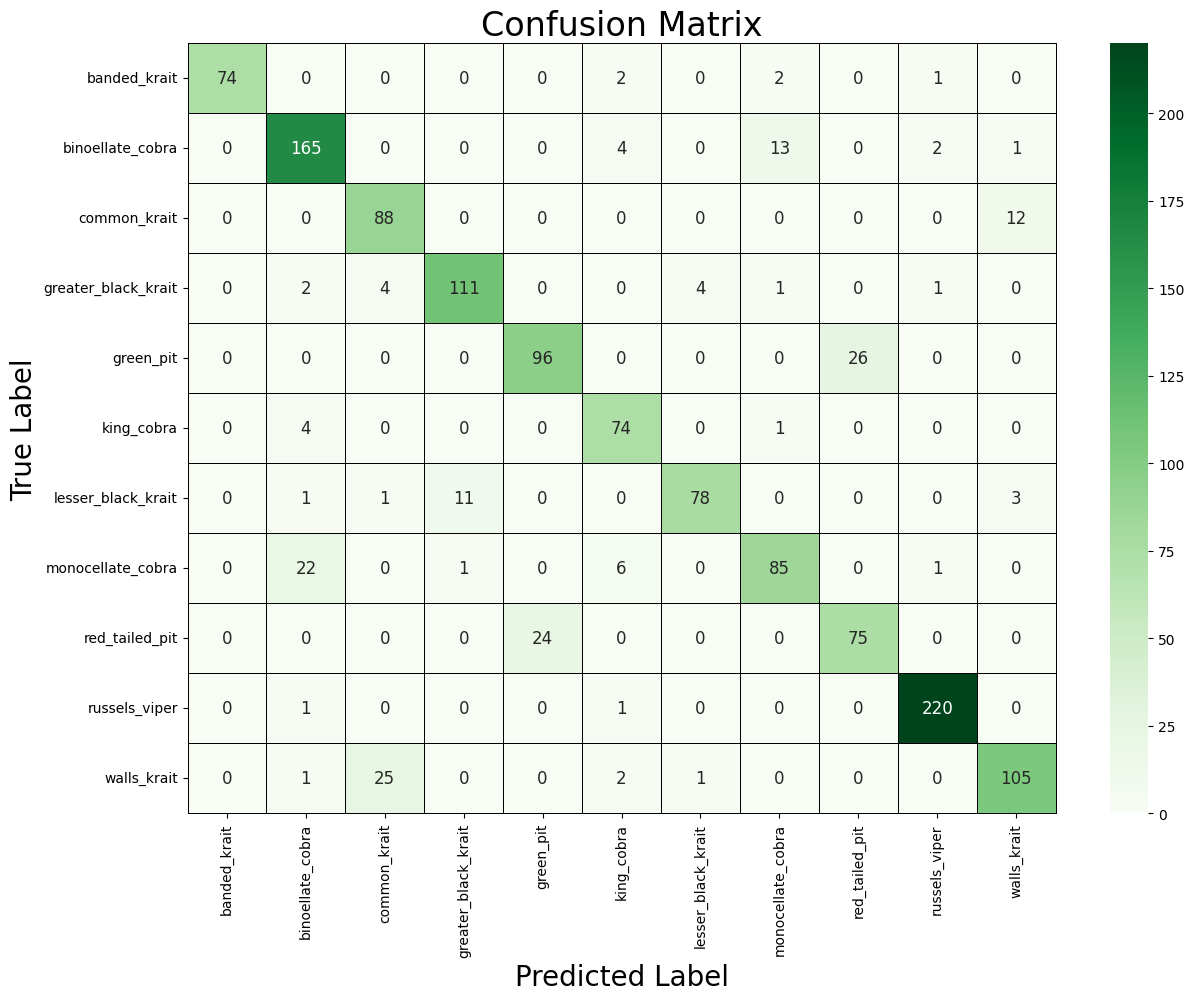

<Figure size 640x480 with 0 Axes>

In [86]:
plot_confusion_matrix(
    test_df.label_encoded, 
    geometric_mean_predictions, 
    figsize=(14, 10), 
    classes=class_names)
plt.savefig(f'/kaggle/working/geometric_mean_confusion_matrix.jpg')

In [87]:
# Densenet Report
print(classification_report(test_df.label_encoded, 
                            densenet_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       0.99      0.94      0.96        79
   binoellate_cobra       0.88      0.84      0.86       185
       common_krait       0.68      0.81      0.74       100
greater_black_krait       0.83      0.78      0.81       123
          green_pit       0.75      0.75      0.75       122
         king_cobra       0.73      0.86      0.79        79
 lesser_black_krait       0.80      0.83      0.82        94
  monocellate_cobra       0.75      0.74      0.74       115
     red_tailed_pit       0.68      0.70      0.69        99
      russels_viper       0.99      0.97      0.98       222
        walls_krait       0.80      0.72      0.76       134

           accuracy                           0.82      1352
          macro avg       0.81      0.81      0.81      1352
       weighted avg       0.83      0.82      0.82      1352



In [88]:
# vgg16 Report
print(classification_report(test_df.label_encoded, 
                            vgg16_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       0.89      0.73      0.81        79
   binoellate_cobra       0.70      0.66      0.68       185
       common_krait       0.51      0.58      0.54       100
greater_black_krait       0.60      0.62      0.61       123
          green_pit       0.57      0.58      0.58       122
         king_cobra       0.52      0.22      0.30        79
 lesser_black_krait       0.67      0.66      0.67        94
  monocellate_cobra       0.52      0.35      0.42       115
     red_tailed_pit       0.56      0.58      0.57        99
      russels_viper       0.65      0.94      0.77       222
        walls_krait       0.50      0.46      0.48       134

           accuracy                           0.62      1352
          macro avg       0.61      0.58      0.58      1352
       weighted avg       0.61      0.62      0.60      1352



In [89]:
# mobilenet V2 Report
print(classification_report(test_df.label_encoded, 
                            mobilenet_v2_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       0.97      0.94      0.95        79
   binoellate_cobra       0.83      0.76      0.79       185
       common_krait       0.74      0.75      0.74       100
greater_black_krait       0.85      0.86      0.85       123
          green_pit       0.72      0.84      0.78       122
         king_cobra       0.74      0.92      0.82        79
 lesser_black_krait       0.93      0.81      0.86        94
  monocellate_cobra       0.66      0.78      0.72       115
     red_tailed_pit       0.75      0.62      0.68        99
      russels_viper       0.99      0.95      0.97       222
        walls_krait       0.81      0.79      0.80       134

           accuracy                           0.82      1352
          macro avg       0.82      0.82      0.82      1352
       weighted avg       0.83      0.82      0.82      1352



In [90]:
# Resnet V2 Report
print(classification_report(test_df.label_encoded, 
                            resnet_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       0.97      0.94      0.95        79
   binoellate_cobra       0.84      0.88      0.85       185
       common_krait       0.72      0.71      0.71       100
greater_black_krait       0.83      0.91      0.87       123
          green_pit       0.81      0.63      0.71       122
         king_cobra       0.85      0.86      0.86        79
 lesser_black_krait       0.95      0.79      0.86        94
  monocellate_cobra       0.80      0.70      0.74       115
     red_tailed_pit       0.65      0.82      0.72        99
      russels_viper       0.99      0.99      0.99       222
        walls_krait       0.72      0.80      0.76       134

           accuracy                           0.83      1352
          macro avg       0.83      0.82      0.82      1352
       weighted avg       0.84      0.83      0.83      1352



In [91]:
# ViT-b16 Report
print(classification_report(test_df.label_encoded, 
                            vit_b16_test_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       0.97      0.96      0.97        79
   binoellate_cobra       0.78      0.83      0.81       185
       common_krait       0.71      0.78      0.74       100
greater_black_krait       0.80      0.90      0.85       123
          green_pit       0.71      0.75      0.73       122
         king_cobra       0.79      0.85      0.82        79
 lesser_black_krait       0.86      0.84      0.85        94
  monocellate_cobra       0.76      0.57      0.65       115
     red_tailed_pit       0.68      0.62      0.65        99
      russels_viper       0.97      0.99      0.98       222
        walls_krait       0.81      0.73      0.77       134

           accuracy                           0.81      1352
          macro avg       0.80      0.80      0.80      1352
       weighted avg       0.81      0.81      0.81      1352



In [92]:
# Average Ensemble Report
print(classification_report(test_df.label_encoded, 
                            avg_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       1.00      0.97      0.99        79
   binoellate_cobra       0.88      0.90      0.89       185
       common_krait       0.74      0.84      0.79       100
greater_black_krait       0.88      0.90      0.89       123
          green_pit       0.77      0.79      0.78       122
         king_cobra       0.84      0.94      0.89        79
 lesser_black_krait       0.91      0.86      0.89        94
  monocellate_cobra       0.84      0.79      0.82       115
     red_tailed_pit       0.73      0.72      0.72        99
      russels_viper       1.00      0.99      1.00       222
        walls_krait       0.87      0.79      0.83       134

           accuracy                           0.87      1352
          macro avg       0.86      0.86      0.86      1352
       weighted avg       0.87      0.87      0.87      1352



In [93]:
# Weighted Average Ensemble Report
print(classification_report(test_df.label_encoded, 
                            weighted_avg_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       1.00      0.97      0.99        79
   binoellate_cobra       0.88      0.90      0.89       185
       common_krait       0.75      0.83      0.79       100
greater_black_krait       0.88      0.90      0.89       123
          green_pit       0.79      0.79      0.79       122
         king_cobra       0.83      0.92      0.87        79
 lesser_black_krait       0.93      0.86      0.90        94
  monocellate_cobra       0.85      0.79      0.82       115
     red_tailed_pit       0.74      0.75      0.74        99
      russels_viper       1.00      0.99      0.99       222
        walls_krait       0.86      0.80      0.83       134

           accuracy                           0.87      1352
          macro avg       0.86      0.86      0.86      1352
       weighted avg       0.87      0.87      0.87      1352



In [94]:
# Geometric Mean Ensemble Report
print(classification_report(test_df.label_encoded, 
                            geometric_mean_predictions, 
                            target_names=class_names))

                     precision    recall  f1-score   support

       banded_krait       1.00      0.94      0.97        79
   binoellate_cobra       0.84      0.89      0.87       185
       common_krait       0.75      0.88      0.81       100
greater_black_krait       0.90      0.90      0.90       123
          green_pit       0.80      0.79      0.79       122
         king_cobra       0.83      0.94      0.88        79
 lesser_black_krait       0.94      0.83      0.88        94
  monocellate_cobra       0.83      0.74      0.78       115
     red_tailed_pit       0.74      0.76      0.75        99
      russels_viper       0.98      0.99      0.98       222
        walls_krait       0.87      0.78      0.82       134

           accuracy                           0.87      1352
          macro avg       0.86      0.86      0.86      1352
       weighted avg       0.87      0.87      0.87      1352



In [95]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(y_true, y_probabilities, k=3)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'top_3_accuracy': top_3_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores


In [96]:
# Generate Densenet model performance scores
densenet_performance = generate_preformance_scores(test_df.label_encoded,
                                                          densenet_test_predictions, 
                                                          densenet_test_probabilities)


Performance Metrics:

accuracy_score:		0.8210

_____________________________________________
top_3_accuracy_score:	0.9845

_____________________________________________
precision_score:	0.8252

_____________________________________________
recall_score:		0.8210

_____________________________________________
f1_score:		0.8220

_____________________________________________
matthews_corrcoef:	0.8012



In [97]:
# Generate Vgg16 model performance scores
vgg16_performance = generate_preformance_scores(test_df.label_encoded,
                                                          vgg16_test_predictions, 
                                                          vgg16_test_probabilities)


Performance Metrics:

accuracy_score:		0.6154

_____________________________________________
top_3_accuracy_score:	0.8772

_____________________________________________
precision_score:	0.6106

_____________________________________________
recall_score:		0.6154

_____________________________________________
f1_score:		0.6028

_____________________________________________
matthews_corrcoef:	0.5713



In [98]:
# Generate MobileNet model performance scores
mobilenet_v2_performance = generate_preformance_scores(test_df.label_encoded,
                                                          mobilenet_v2_test_predictions, 
                                                          mobilenet_v2_test_probabilities)


Performance Metrics:

accuracy_score:		0.8232

_____________________________________________
top_3_accuracy_score:	0.9808

_____________________________________________
precision_score:	0.8300

_____________________________________________
recall_score:		0.8232

_____________________________________________
f1_score:		0.8241

_____________________________________________
matthews_corrcoef:	0.8040



In [99]:
# Generate Resnet model performance scores
resnet_performance = generate_preformance_scores(test_df.label_encoded,
                                                          resnet_test_predictions, 
                                                          resnet_test_probabilities)


Performance Metrics:

accuracy_score:		0.8321

_____________________________________________
top_3_accuracy_score:	0.9911

_____________________________________________
precision_score:	0.8378

_____________________________________________
recall_score:		0.8321

_____________________________________________
f1_score:		0.8319

_____________________________________________
matthews_corrcoef:	0.8136



In [100]:
# Generate ViT model performance scores
vit_b16_performance = generate_preformance_scores(test_df.label_encoded,
                                                  vit_b16_test_predictions, 
                                                  vit_b16_test_probabilities)


Performance Metrics:

accuracy_score:		0.8136

_____________________________________________
top_3_accuracy_score:	0.9926

_____________________________________________
precision_score:	0.8133

_____________________________________________
recall_score:		0.8136

_____________________________________________
f1_score:		0.8114

_____________________________________________
matthews_corrcoef:	0.7928



In [101]:
# Generate Average Ensemble performance scores
avg_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                       avg_predictions, 
                                                       avg_probabilities)


Performance Metrics:

accuracy_score:		0.8706

_____________________________________________
top_3_accuracy_score:	0.9904

_____________________________________________
precision_score:	0.8722

_____________________________________________
recall_score:		0.8706

_____________________________________________
f1_score:		0.8707

_____________________________________________
matthews_corrcoef:	0.8561



In [102]:
# Generate Weighted Average Ensemble performance scores
weigthed_avg_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                                weighted_avg_predictions, 
                                                                weighted_avg_probabilities)


Performance Metrics:

accuracy_score:		0.8728

_____________________________________________
top_3_accuracy_score:	0.9919

_____________________________________________
precision_score:	0.8745

_____________________________________________
recall_score:		0.8728

_____________________________________________
f1_score:		0.8730

_____________________________________________
matthews_corrcoef:	0.8585



In [103]:
# Generate Geometric Mean Ensemble performance scores
geometric_mean_ensemble_performance = generate_preformance_scores(test_df.label_encoded,
                                                                geometric_mean_predictions, 
                                                                geometric_mean_probabilities)


Performance Metrics:

accuracy_score:		0.8661

_____________________________________________
top_3_accuracy_score:	0.9896

_____________________________________________
precision_score:	0.8688

_____________________________________________
recall_score:		0.8661

_____________________________________________
f1_score:		0.8660

_____________________________________________
matthews_corrcoef:	0.8512



In [104]:
# Record metrics with DataFrame
performance_df = pd.DataFrame({
    'model_densenet': densenet_performance,
    'model_vgg16': vgg16_performance,
    'model_mobilenet_v2': mobilenet_v2_performance,
    'model_resnet': resnet_performance,
    'model_vit_b16': vit_b16_performance,
    'average_ensemble': avg_ensemble_performance,
    'weigthed_average_ensemble': weigthed_avg_ensemble_performance,
    'geometric_mean_ensemble': geometric_mean_ensemble_performance
}).T

# View Performance DataFrame
performance_df

accuracy_score  top_3_accuracy  precision_score  \
model_densenet                   0.821006        0.984467         0.825238   
model_vgg16                      0.615385        0.877219         0.610637   
model_mobilenet_v2               0.823225        0.980769         0.829983   
model_resnet                     0.832101        0.991124         0.837834   
model_vit_b16                    0.813609        0.992604         0.813267   
average_ensemble                 0.870562        0.990385         0.872239   
weigthed_average_ensemble        0.872781        0.991864         0.874460   
geometric_mean_ensemble          0.866124        0.989645         0.868813   

                           recall_score  f1_score  matthews_corrcoef  
model_densenet                 0.821006  0.821957           0.801216  
model_vgg16                    0.615385  0.602814           0.571288  
model_mobilenet_v2             0.823225  0.824085           0.803988  
model_resnet                   0.832101  0.831932           0.813601  
model_vit_b16                  0.813609  0.811407           0.792802  
average_ensemble               0.870562  0.870694           0.856090  
weigthed_average_ensemble      0.872781  0.872959           0.858522  
geometric_mean_ensemble        0.866124  0.866008           0.851193

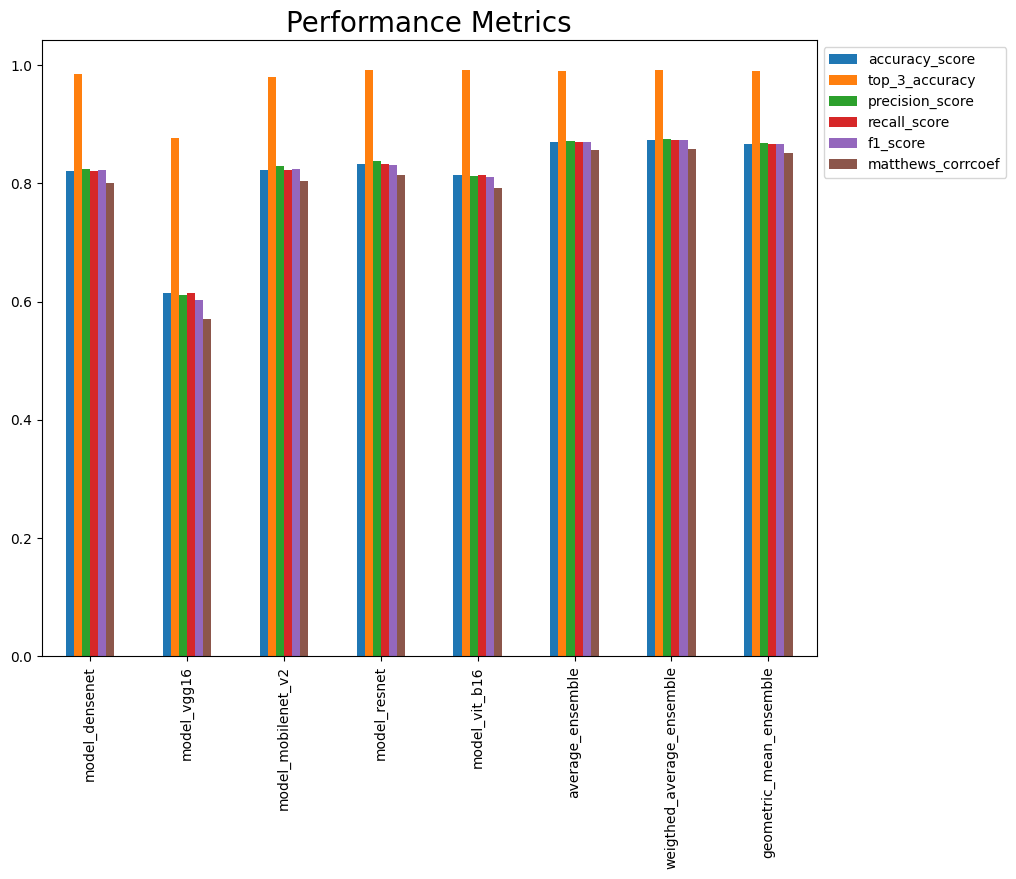

In [105]:
performance_df.plot(kind="bar", figsize=(10, 8)).legend(bbox_to_anchor=(1.0, 1.0))
plt.title('Performance Metrics', fontsize=20);
plt.savefig(f'/kaggle/working/performance_metrics.jpg')

In [106]:
def compute_inference_time(model, ds, sample_count, inference_runs=5):
    total_inference_times = []
    inference_rates = []
    
    for _ in range(inference_runs):
        start = time.perf_counter()
        model.predict(ds, verbose=0)
        end = time.perf_counter() 
        
        # Compute total inference time
        total_inference_time = end - start
        
        # Compute inference rate
        inference_rate = total_inference_time / sample_count
        
        total_inference_times.append(total_inference_time)
        inference_rates.append(inference_rate)
    
    # Calculate average total inference time with uncertainty
    avg_inference_time = sum(total_inference_times) / len(total_inference_times)
    avg_inference_time_uncertainty = (max(total_inference_times) - min(total_inference_times)) / 2
    
    # Calculate average inference rate with uncertainty
    avg_inference_rate = sum(inference_rates) / len(inference_rates)
    avg_inference_rate_uncertainty = (max(inference_rates) - min(inference_rates)) / 2
    
    print('====================================================')
    print(f'Model:\t\t{model.name}\n')
    print(f'Inference Time:\t{round(avg_inference_time, 6)}s \xB1 {round(avg_inference_time_uncertainty, 6)}s')
    print(f'Inference Rate:\t{round(avg_inference_rate, 6)}s/sample \xB1 {round(avg_inference_rate_uncertainty, 6)}s/sample')
    print('====================================================')
    
    return avg_inference_time, avg_inference_rate

In [107]:
densenet_inference = compute_inference_time(model_densenet, test_ds, len(test_df))

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


Model:		sequential

Inference Time:	23.437707s ± 1.250591s
Inference Rate:	0.017336s/sample ± 0.000925s/sample


In [108]:
vgg16_inference = compute_inference_time(model_vgg16, test_ds, len(test_df))

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


Model:		sequential_1

Inference Time:	37.360453s ± 9.06457s
Inference Rate:	0.027633s/sample ± 0.006705s/sample


In [109]:
mobilenet_v2_inference = compute_inference_time(model_mobileNet_v2, test_ds, len(test_df))

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


Model:		mobileNet_v2_sequential_model

Inference Time:	30.12669s ± 9.16889s
Inference Rate:	0.022283s/sample ± 0.006782s/sample


In [110]:
resnet_inference = compute_inference_time(model_resnet, test_ds, len(test_df))

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


Model:		resnet_sequential_model

Inference Time:	39.303454s ± 4.210797s
Inference Rate:	0.029071s/sample ± 0.003114s/sample


In [ ]:
vit_b16_inference = compute_inference_time(model_vit_b16, test_ds, len(test_df))

Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda
Corrupt JPEG data: 65536 extraneous bytes before marker 0xda


In [ ]:
# We assume all ensembles to have the total inference of all models
ensemble_inference = (
    densenet_inference[0] + vgg16_inference[0] + mobilenet_v2_inference[0] + resnet_inference[0] + vit_b16_inference[0],
    densenet_inference[1] + vgg16_inference[1] + mobilenet_v2_inference[1] + resnet_inference[1] + vit_b16_inference[1]
)

print('====================================================')
print(f'Model:\t\tAverage/Weighted Average Ensemble\n')
print(f'Inference Time:\t{ensemble_inference[0]:.6f}s')
print(f'Inference Rate:\t{ensemble_inference[1]:.6f}s/sample')
print('====================================================')

In [ ]:
# Get MCC for each model
densenet_mcc = densenet_performance["matthews_corrcoef"]
vgg16_mcc = vgg16_performance["matthews_corrcoef"]
mobilenet_mcc = mobilenet_v2_performance["matthews_corrcoef"]
resnet_mcc = resnet_performance["matthews_corrcoef"]
vit_mcc = vit_b16_performance["matthews_corrcoef"]
avg_mcc = avg_ensemble_performance['matthews_corrcoef']
weighted_mcc = weigthed_avg_ensemble_performance['matthews_corrcoef']
geometric_mcc = geometric_mean_ensemble_performance['matthews_corrcoef']

# Scatter plot inference rate against MCC
plt.figure(figsize=(12, 7))

# plt.scatter(cnn_inference[1], cnn_mcc, label=model_cnn.name)
plt.scatter(densenet_inference[1], densenet_mcc, label=model_densenet.name)
plt.scatter(vgg16_inference[1], vgg16_mcc, label=model_vgg16.name)
plt.scatter(mobilenet_v2_inference[1], mobilenet_mcc, label=model_mobileNet_v2.name)
plt.scatter(resnet_inference[1], resnet_mcc, label=model_resnet.name)
plt.scatter(vit_b16_inference[1], vit_mcc, label=model_vit_b16.name)
plt.scatter(ensemble_inference[1], avg_mcc, label='Average Ensemble')
plt.scatter(ensemble_inference[1], weighted_mcc, label='Weighted Average Ensemble')
plt.scatter(ensemble_inference[1], geometric_mcc, label='Geometric Mean Ensemble')

ideal_inference_rate = 0.0001 # Desired inference time (Exaggerated)
ideal_mcc = 1 # Max MCC 

# Plot lines connecting each model coords. to the ideal model coords.
plt.scatter(ideal_inference_rate, ideal_mcc, label="Ideal Hypothetical Model", marker='s')
plt.plot([ideal_inference_rate, densenet_inference[1]], [ideal_mcc, densenet_mcc], ':')
plt.plot([ideal_inference_rate, vgg16_inference[1]], [ideal_mcc, vgg16_mcc], ':')

plt.plot([ideal_inference_rate, mobilenet_v2_inference[1]], [ideal_mcc, mobilenet_mcc], ':')
plt.plot([ideal_inference_rate, resnet_inference[1]], [ideal_mcc, resnet_mcc], ':')

plt.plot([ideal_inference_rate, vit_b16_inference[1]], [ideal_mcc, vit_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, avg_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, weighted_mcc], ':')
plt.plot([ideal_inference_rate, ensemble_inference[1]], [ideal_mcc, geometric_mcc], ':')

plt.legend()
plt.title("Trade-Offs: Inference Rate vs. Matthews Correlation Coefficient", fontsize=20)
plt.xlabel("Inference Rate (s/sample)", fontsize=16)
plt.ylabel("Matthews Correlation Coefficient", fontsize=16);

In [ ]:
def dist(x1, x2, y1, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

# List model names
model_names = [
    model_densenet.name, 
    model_vgg16.name, 
    model_mobileNet_v2.name, 
    model_resnet.name, 
    model_vit_b16.name,
    'Average Ensemble',
    'Weighted Average Ensemble',
    'Geometric Mean Ensemble'
]

# List model mcc scores
model_scores = [
    densenet_mcc,
    vgg16_mcc,
    mobilenet_mcc,
    resnet_mcc,
    vit_mcc,
    avg_mcc,
    weighted_mcc,
    geometric_mcc
]

# List model inference rates
model_rates = [
    densenet_inference[1], 
    vgg16_inference[1], 
    mobilenet_v2_inference[1], 
    resnet_inference[1], 
    vit_b16_inference[1],
    ensemble_inference[1],
    ensemble_inference[1],
    ensemble_inference[1]
]

# Compute trade-off's
trade_offs = [dist(ideal_inference_rate, inference_rate, ideal_mcc, score) 
              for inference_rate, score in zip(model_rates, model_scores)]

# View model trade-off scores
print('Trade-Off Score: Inference Rate vs. MCC')
for name, inference_rate, score, trade in zip(model_names, model_rates, model_scores, trade_offs):
    print('---------------------------------------------------------')
    print(f'Model: {name}\n\nInference Rate: {inference_rate:.5f} | MCC: {score:.4f} | Trade-Off: {trade:.4f}')

# View model with best trade-off score
print('=========================================================')
best_model_trade = min(trade_offs)
best_model_name = model_names[np.argmin(trade_offs)]
print(f'\nBest Optimal Model:\t{best_model_name}\nTrade-Off:\t\t{best_model_trade:.4f}\n')
print('=========================================================')

In [ ]:
import tensorflow.keras
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import keras
import keras.utils
from keras import utils as np_utils
import tensorflow_hub as hub


# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
keras_model_densenet = tensorflow.keras.models.load_model('/kaggle/working/densenet.h5', compile=False)
keras_model_densenet._name = 'model_densenet'
keras_model_vgg16 = tensorflow.keras.models.load_model('/kaggle/working/vgg16.h5', compile=False)
keras_model_vgg16._name = 'model_vgg16'
keras_model_mobilenet = tf.keras.models.load_model(('/kaggle/working/mobilenet.h5'),custom_objects={'KerasLayer':hub.KerasLayer})
keras_model_mobilenet._name = 'model_mobilenet'
keras_model_resnet = keras.models.load_model('/kaggle/working/resnet.h5', compile=False)
keras_model_resnet._name = 'model_resnet'
keras_model_vit = tensorflow.keras.models.load_model('/kaggle/working/vit.h5', compile=False)
keras_model_vit._name = 'model_vit'
models = [keras_model_densenet, keras_model_vgg16, keras_model_mobilenet, keras_model_resnet, keras_model_vit]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.save('ensemble_vgg_dense_mobilenet_resnet_vit.h5')

In [ ]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/ensemble_vgg_dense_mobilenet_resnet_vit.h5')